# All oscillation analysis

Brief 1-2 sentence description of notebook.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import collections
import itertools
from collections import defaultdict

In [3]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mannwhitneyu

In [4]:
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import colorsys

In [5]:
from scipy.stats import linregress

In [6]:
from sklearn.metrics import confusion_matrix

In [7]:
from spectral_connectivity import Multitaper, Connectivity
import spectral_connectivity

In [8]:
FONTSIZE = 20

In [9]:
font = {'weight' : 'medium',
        'size'   : 20}

matplotlib.rc('font', **font)

## Inputs & Data

Explanation of each input and where it comes from.

In [10]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs

In [11]:
CHANNEL_MAP_AND_ALL_TRIALS_DF = pd.read_pickle("./proc/full_baseline_and_trial_lfp_traces.pkl")
MERGED_TRIALS_AND_VIDEO = pd.read_pickle("./proc/trial_SLEAP_and_metadata.pkl")

In [12]:
OUTCOME_TO_COLOR = {'lose': "red",
 'omission': "orange",
 'rewarded': "green",
 'win': "blue"}

OUTCOME_TO_COLOR = {'lose': "#951a1d",
 'omission': "#af780d",
 'rewarded': "#0499af",
 'win': "#3853a3"}

In [13]:
OUTCOME_COMPARISONS = {"win_lose": ("win", "lose"), "lose_omission": ("lose", "omission"), "win_rewarded": ("win", "rewarded")}

In [14]:
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}

In [15]:
TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 1
TIME_WINDOW_STEP = 0.5
RESAMPLE_RATE=1000

In [16]:
BIN_TO_DISTANCE = {0: "0 to 5cm", 1: "5cm+"}

In [17]:
MIN_DISTANCE = 0
MAX_DISTANCE = 5

In [18]:
ALL_BANDS = ["theta", "beta", "gamma"]
BAND_TO_FREQ = {"theta": {"low_freq": 6, "high_freq": 11}, "beta": {"low_freq": 20, "high_freq": 31}, "gamma": {"low_freq": 30, "high_freq": 51}}
BAND_TO_FREQ = {"theta": (6,11), "beta": (20,31), "gamma": (30,51)}

In [19]:
GROUPINGS = "trial_outcome"

In [20]:
FONTSIZE=20

In [21]:
MERGED_TRIALS_AND_VIDEO.head()

time                                      recording_dir  \
0   4509412  20230617_115521_standard_comp_to_omission_D1_s...   
1   6909411  20230617_115521_standard_comp_to_omission_D1_s...   
2   9209413  20230617_115521_standard_comp_to_omission_D1_s...   
3  13109412  20230617_115521_standard_comp_to_omission_D1_s...   
4  16509409  20230617_115521_standard_comp_to_omission_D1_s...   

                                      recording_file  time_stamp_index  \
0  20230617_115521_standard_comp_to_omission_D1_s...           1030879   
1  20230617_115521_standard_comp_to_omission_D1_s...           3430878   
2  20230617_115521_standard_comp_to_omission_D1_s...           5730880   
3  20230617_115521_standard_comp_to_omission_D1_s...           9630879   
4  20230617_115521_standard_comp_to_omission_D1_s...          13030876   

                                          video_file  video_frame  \
0  20230617_115521_standard_comp_to_omission_D1_s...         1029   
1  20230617_115521_standard_comp_to_omission_D1_s...         3425   
2  20230617_115521_standard_comp_to_omission_D1_s...         5720   
3  20230617_115521_standard_comp_to_omission_D1_s...         9612   
4  20230617_115521_standard_comp_to_omission_D1_s...        13006   

   video_number    subject_info competition_closeness  \
0           1.0  1-1_t1b3L_box1             lose_comp   
1           1.0  1-1_t1b3L_box1              win_comp   
2           1.0  1-1_t1b3L_box1              win_comp   
3           1.0  1-1_t1b3L_box1              win_comp   
4           1.0  1-1_t1b3L_box1              win_comp   

                                          video_name  ...  \
0  20230617_115521_standard_comp_to_omission_D1_s...  ...   
1  20230617_115521_standard_comp_to_omission_D1_s...  ...   
2  20230617_115521_standard_comp_to_omission_D1_s...  ...   
3  20230617_115521_standard_comp_to_omission_D1_s...  ...   
4  20230617_115521_standard_comp_to_omission_D1_s...  ...   

   chunked_baseline_subject_thorax_to_agent_distance  \
0  [12.65717198847138, 12.683871307928696, 14.880...   
1  [25.320573976061063, 25.371420577329687, 25.41...   
2  [10.449518193779662, 10.328848927104168, 9.348...   
3  [22.46126034089424, 15.271962513097026, 9.7552...   
4  [14.852791816182672, 14.876901938207157, 14.76...   

      chunked_trial_subject_thorax_to_agent_distance  \
0  [16.205996400456687, 14.683460926448209, 10.78...   
1  [28.298667296783595, 27.888632992419563, 26.34...   
2  [14.112370366297414, 10.711508418394406, 6.929...   
3  [2.6010760116473928, 2.4955147120669183, 2.936...   
4  [9.364399513304493, 8.907949164940378, 8.22304...   

  chunked_baseline_subject_and_agent_to_reward_port_distance_ratio  \
0  [0.604891584042554, 0.5436686554497678, 0.3929...                 
1  [15.7376508983956, 15.425234033778917, 14.3912...                 
2  [0.44937492745252716, 0.9597410167684043, 1.26...                 
3  [0.535834249250867, 0.5909067784974122, 0.4167...                 
4  [0.1524447125009488, 0.15444116914230885, 0.14...                 

   chunked_trial_subject_and_agent_to_reward_port_distance_ratio  \
0  [8.855775558856838, 8.071331610027782, 6.34917...               
1  [5.900235036905437, 5.7618199879648, 5.5222346...               
2  [0.14051079708270506, 0.2589369756582887, 0.40...               
3  [0.33382427611833676, 0.36024075728364263, 0.2...               
4  [0.36101539914136693, 0.3941705997491232, 0.41...               

  binned_trial_subject_thorax_to_reward_port_distance  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...    
1  [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...    
2  [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...    
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    

   binned_trial_agent_thorax_to_reward_port_distance  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, ...   
2  [1, 1, 1, 1, 1, 1, 1, 

In [22]:
CHANNEL_MAP_AND_ALL_TRIALS_DF.head()

time                                      recording_dir  \
0   6310663  20221202_134600_omission_and_competition_subje...   
1   7910662  20221202_134600_omission_and_competition_subje...   
2   9710660  20221202_134600_omission_and_competition_subje...   
3  11310658  20221202_134600_omission_and_competition_subje...   
4  12810657  20221202_134600_omission_and_competition_subje...   

                                      recording_file  time_stamp_index  \
0  20221202_134600_omission_and_competition_subje...           1390826   
1  20221202_134600_omission_and_competition_subje...           2990825   
2  20221202_134600_omission_and_competition_subje...           4790823   
3  20221202_134600_omission_and_competition_subje...           6390821   
4  20221202_134600_omission_and_competition_subje...           7890820   

                                          video_file  video_frame  \
0  20221202_134600_omission_and_competition_subje...         1734   
1  20221202_134600_omission_and_competition_subje...         3728   
2  20221202_134600_omission_and_competition_subje...         5972   
3  20221202_134600_omission_and_competition_subje...         7966   
4  20221202_134600_omission_and_competition_subje...         9836   

   video_number      subject_info competition_closeness  \
0           1.0  6_1_top_2_base_3              rewarded   
1           1.0  6_1_top_2_base_3              rewarded   
2           1.0  6_1_top_2_base_3              rewarded   
3           1.0  6_1_top_2_base_3              omission   
4           1.0  6_1_top_2_base_3              rewarded   

                                          video_name  ...  \
0  20221202_134600_omission_and_competition_subje...  ...   
1  20221202_134600_omission_and_competition_subje...  ...   
2  20221202_134600_omission_and_competition_subje...  ...   
3  20221202_134600_omission_and_competition_subje...  ...   
4  20221202_134600_omission_and_competition_subje...  ...   

                     vHPC_baselineandtrial_lfp_trace  \
0  [-0.07045184, -0.0958607, -0.054282565, 0.1512...   
1  [0.30606127, 0.22405995, 0.28873706, 0.4100066...   
2  [-1.2300198, -1.2323297, -1.3039365, -1.096045...   
3  [0.1605378, 0.4169363, 0.64561605, 0.6756447, ...   
4  [-0.30952612, 0.19056645, 0.4331056, 0.3638087...   

                              BLA_baseline_lfp_trace  \
0  [2.0367692, 2.1165679, 2.162167, 2.2685654, 2....   
1  [0.30589536, 0.13679792, -0.064599015, -0.3381...   
2  [-2.0025697, -1.9151709, -1.9436705, -1.552276...   
3  [-1.2729807, -1.0468841, -0.8378873, -0.754288...   
4  [-2.1469674, -2.0690687, -2.0937681, -2.152667...   

                                 BLA_trial_lfp_trace  \
0  [0.31159526, 0.35909453, 0.18239723, -0.509192...   
1  [0.020899683, -0.05129922, 0.113998264, -0.416...   
2  [0.6896895, 1.3983787, 1.7574733, 1.4287783, 1...   
3  [2.6789594, 2.3939636, 2.2096665, 1.97597, 1.8...   
4  [-0.18809713, 0.108298354, -0.66878986, -0.944...   

                      BLA_baselineandtrial_lfp_trace  \
0  [2.0367692, 2.1165679, 2.162167, 2.2685654, 2....   
1  [0.30589536, 0.13679792, -0.064599015, -0.3381...   
2  [-2.0025697, -1.9151709, -1.9436705, -1.552276...   
3  [-1.2729807, -1.0468841, -0.8378873, -0.754288...   
4  [-2.1469674, -2.0690687, -2.0937681, -2.152667...   

                               LH_baseline_lfp_trace  \
0  [3.0443187, 3.1354659, 3.1810396, 3.1901543, 3...   
1  [-1.1575702, -1.2699852, -1.3489795, -1.427973...   
2  [-0.20356221, -0.08203254, -0.18837102, -0.142...   
3  [-2.4792056, -2.1480372, -1.8259835, -1.677109...   
4  [-2.1176548, -1.4522797, -1.0360405, -1.108958...   

                                  LH_trial_lfp_trace  \
0  [0.78082824, 1.1788379, 0.8415931, -0.40104795...   
1  [0.91754913, 0.4466216, 0.64410734, 0.03342066...   
2  [-0.58941895, 0.25521234, 0.66233677, 0.416239...   
3  [2.7587237, 2.233108, 1.4796239, 0.93274033, 1...   
4  [0.5104247, 1.4613944, 0.5468836, -0.036458906...   

      

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Functions 

In [23]:
def generate_pairs(lst):
    pairs = []
    n = len(lst)
    for i in range(n):
        for j in range(i+1, n):
            pairs.append((lst[i], lst[j]))
    return pairs

In [24]:
def nested_dict():
    return defaultdict(dict)

In [25]:
def mean_of_counter(counter):
    # Extract values from the Counter and calculate the mean
    values = list(counter.values())
    return sum(values) / len(values) if values else 0  # Prevent division by zero

In [26]:
def adjust_lightness(color, amount=0.5):
    """
    Adjusts the lightness of the given color by the provided amount.
    :param color: Input color in some format that matplotlib's `to_rgb` can handle.
    :param amount: Amount to adjust. > 1 for lighter, < 1 for darker.
    :return: Adjusted color.
    """
    import colorsys
    c = mcolors.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(*c)
    return colorsys.hls_to_rgb(h, max(0, min(1, amount * l)), s)

In [27]:
def generate_gradient_colors(base_color, num_colors=10):
    """
    Generate gradient colors based on a base color.
    
    :param base_color: The base color to create a gradient from.
    :param num_colors: The number of gradient colors to generate.
    :return: List of colors.
    """
    # Convert base color to HLS (Hue, Lightness, Saturation)
    h, l, s = colorsys.rgb_to_hls(*mcolors.to_rgb(base_color))

    # Determine the step size for lightness
    middle_index = num_colors // 2
    lightness_step = l / (middle_index if middle_index > 0 else 1)

    colors = []
    for i in range(num_colors):
        if i < middle_index:
            # For the lighter colors (before the middle)
            new_lightness = l + (middle_index - i) * lightness_step
        elif i == middle_index:
            # The middle color remains the base color
            new_lightness = l
        else:
            # For the darker colors (after the middle)
            new_lightness = l - (i - middle_index) * lightness_step

        # Ensure new lightness is within the valid range [0, 1]
        new_lightness = max(0, min(new_lightness, 1))

        new_color = colorsys.hls_to_rgb(h, new_lightness, s)
        colors.append(new_color)

    return colors

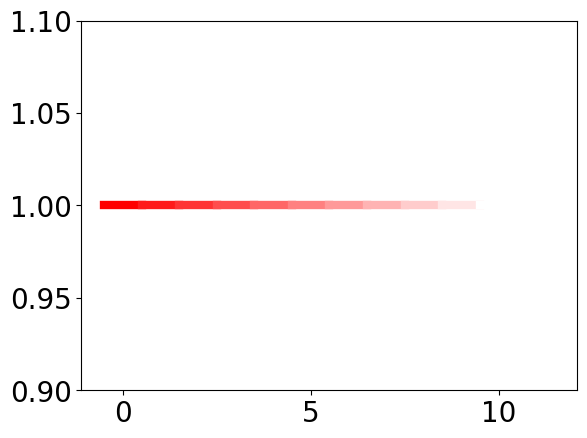

In [28]:
# Original color
original_color = 'red'  # Can be any color matplotlib understands

# Generate lighter versions
lighter_colors = [adjust_lightness(original_color, amount=1+(0.1*i)) for i in range(12)]

# Plotting to demonstrate the colors
for i, color in enumerate(lighter_colors):
    plt.plot([i-0.5, i+0.5], [1, 1], color=color, linewidth=6)  

plt.ylim(0.9, 1.1)
plt.show()

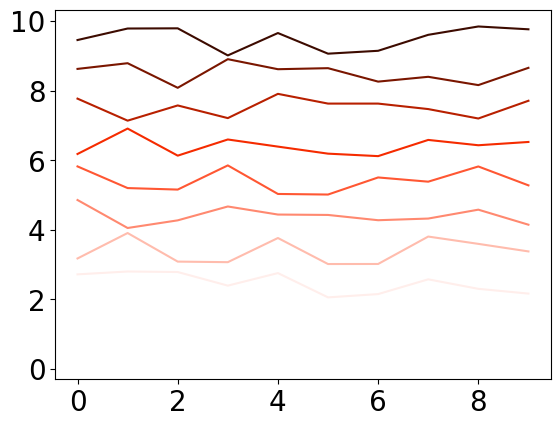

In [29]:
# Base color
base_color = '#ff5733'  # Reddish color

# Number of colors you want in the gradient
num_colors = 10

# Generate gradient colors
gradient_colors = generate_gradient_colors(base_color, num_colors)

# Set the color cycle to use the gradient colors
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=gradient_colors)

# Test by plotting some data
for i in range(num_colors):
    plt.plot(np.arange(10), np.random.rand(10) + i)

plt.show()

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [30]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

# Ideally functions are defined here first and then data is processed using the functions

# function names are short and in snake case all lowercase
# a function name should be unique but does not have to describe the function
# doc strings describe functions not function names




In [31]:
CHANNEL_MAP_AND_ALL_TRIALS_DF.columns

Index(['time', 'recording_dir', 'recording_file', 'time_stamp_index',
       'video_file', 'video_frame', 'video_number', 'subject_info',
       'competition_closeness', 'video_name', 'all_subjects',
       'current_subject', 'trial_outcome', 'lfp_index',
       'baseline_lfp_timestamp_range', 'trial_lfp_timestamp_range',
       'baseline_ephys_timestamp_range', 'trial_ephys_timestamp_range',
       'baseline_videoframe_range', 'trial_videoframe_range', 'trial_number',
       'Cohort', 'spike_interface_mPFC', 'spike_interface_vHPC',
       'spike_interface_BLA', 'spike_interface_LH', 'spike_interface_MD',
       'mPFC_baseline_lfp_trace', 'mPFC_trial_lfp_trace',
       'mPFC_baselineandtrial_lfp_trace', 'vHPC_baseline_lfp_trace',
       'vHPC_trial_lfp_trace', 'vHPC_baselineandtrial_lfp_trace',
       'BLA_baseline_lfp_trace', 'BLA_trial_lfp_trace',
       'BLA_baselineandtrial_lfp_trace', 'LH_baseline_lfp_trace',
       'LH_trial_lfp_trace', 'LH_baselineandtrial_lfp_trace',
       'MD

In [32]:
MERGED_TRIALS_AND_VIDEO.columns

Index(['time', 'recording_dir', 'recording_file', 'time_stamp_index',
       'video_file', 'video_frame', 'video_number', 'subject_info',
       'competition_closeness', 'video_name', 'all_subjects',
       'current_subject', 'trial_outcome', 'lfp_index',
       'baseline_lfp_timestamp_range', 'trial_lfp_timestamp_range',
       'baseline_ephys_timestamp_range', 'trial_ephys_timestamp_range',
       'baseline_videoframe_range', 'trial_videoframe_range', 'trial_number',
       'Cohort', 'spike_interface_mPFC', 'spike_interface_vHPC',
       'spike_interface_BLA', 'spike_interface_LH', 'spike_interface_MD',
       'file_path', 'start_frame', 'stop_frame', 'individual_subj', 'all_subj',
       'recording_name', 'track_names', 'subject_and_tracks_list',
       'subject_id', 'agent_id', 'corner_path', 'corner_parts', 'bottom_width',
       'top_width', 'right_height', 'left_height', 'average_height',
       'average_width', 'width_ratio', 'height_ratio', 'box_bottom_left',
       'reward_po

### Merging LFP Trace dataframe and SLEAP pose tracking

In [33]:
merge_columns = ["time", "recording_file", "current_subject", "video_number"]
# Find columns in df2 that are not in merge_columns and also exist in df1, then drop them from df2
cols_to_drop = [col for col in CHANNEL_MAP_AND_ALL_TRIALS_DF.columns if col not in merge_columns and col in MERGED_TRIALS_AND_VIDEO.columns]
CHANNEL_MAP_AND_ALL_TRIALS_DF = CHANNEL_MAP_AND_ALL_TRIALS_DF.drop(columns=cols_to_drop)

In [34]:
MERGED_LFP_AND_SLEAP = pd.merge(left=CHANNEL_MAP_AND_ALL_TRIALS_DF, right=MERGED_TRIALS_AND_VIDEO, on=merge_columns, how="right")

In [35]:
MERGED_LFP_AND_SLEAP.head()

time                                     recording_file  video_number  \
0   4509412  20230617_115521_standard_comp_to_omission_D1_s...           1.0   
1   6909411  20230617_115521_standard_comp_to_omission_D1_s...           1.0   
2   9209413  20230617_115521_standard_comp_to_omission_D1_s...           1.0   
3  13109412  20230617_115521_standard_comp_to_omission_D1_s...           1.0   
4  16509409  20230617_115521_standard_comp_to_omission_D1_s...           1.0   

  current_subject                            mPFC_baseline_lfp_trace  \
0             1.1  [-1.2365645, -1.3354121, -1.5621803, -1.494343...   
1             1.1  [0.24421181, 0.2616555, 0.4380307, 0.4729181, ...   
2             1.1  [1.7249881, 1.7424319, 1.6862243, 1.4323217, 0...   
3             1.1  [-0.89156693, -1.0485603, -0.7539555, -0.38182...   
4             1.1  [0.79853386, 1.0737567, 1.3412267, 1.6145114, ...   

                                mPFC_trial_lfp_trace  \
0  [-1.0679421, -0.7713992, -0.69580984, -1.13190...   
1  [-0.8605559, -0.6492933, -0.37407047, -0.05233...   
2  [-0.094971254, -0.16862243, -0.12404409, -0.22...   
3  [2.3956015, 2.1804626, 1.9730763, 1.9750146, 2...   
4  [-1.5835004, -1.6067586, -1.2113681, -0.819853...   

                     mPFC_baselineandtrial_lfp_trace  \
0  [-1.2365645, -1.3354121, -1.5621803, -1.494343...   
1  [0.24421181, 0.2616555, 0.4380307, 0.4729181, ...   
2  [1.7249881, 1.7424319, 1.6862243, 1.4323217, 0...   
3  [-0.89156693, -1.0485603, -0.7539555, -0.38182...   
4  [0.79853386, 1.0737567, 1.3412267, 1.6145114, ...   

                             vHPC_baseline_lfp_trace  \
0  [0.20910755, 0.39620376, 0.7075067, 1.040821, ...   
1  [0.5377051, 0.70907897, 0.5219827, 0.3506089, ...   
2  [0.7531016, 0.1776628, -0.37890917, -0.6980733...   
3  [-0.72480136, -0.8631582, -0.610028, 0.1776628...   
4  [0.067606196, 0.3679035, 0.63203937, 0.7059344...   

                                vHPC_trial_lfp_trace  \
0  [-2.4841347, -2.1523926, -1.564376, -1.139872,...   
1  [-0.31916416, -0.08647305, 0.19810188, 0.49525...   
2  [1.2908068, 1.0486822, 0.79712427, 0.55971646,...   
3  [2.0847864, 1.889829, 1.8442342, 1.9480019, 2....   
4  [-1.2845178, -1.1807501, -0.8128466, -0.452804...   

                     vHPC_baselineandtrial_lfp_trace  ...  \
0  [0.20910755, 0.39620376, 0.7075067, 1.040821, ...  ...   
1  [0.5377051, 0.70907897, 0.5219827, 0.3506089, ...  ...   
2  [0.7531016, 0.1776628, -0.37890917, -0.6980733...  ...   
3  [-0.72480136, -0.8631582, -0.610028, 0.1776628...  ...   
4  [0.067606196, 0.3679035, 0.63203937, 0.7059344...  ...   

   chunked_baseline_subject_thorax_to_agent_distance  \
0  [12.65717198847138, 12.683871307928696, 14.880...   
1  [25.320573976061063, 25.371420577329687, 25.41...   
2  [10.449518193779662, 10.328848927104168, 9.348...   
3  [22.46126034089424, 15.271962513097026, 9.7552...   
4  [14.852791816182672, 14.876901938207157, 14.76...   

      chunked_trial_subject_thorax_to_agent_distance  \
0  [16.205996400456687, 14.683460926448209, 10.78...   
1  [28.298667296783595, 27.888632992419563, 26.34...   
2  [14.112370366297414, 10.711508418394406, 6.929...   
3  [2.6010760116473928, 2.4955147120669183, 2.936...   
4  [9.364399513304493, 8.907949164940378, 8.22304...   

  chunked_baseline_subject_and_agent_to_reward_port_distance_ratio  \
0  [0.604891584042554, 0.5436686554497678, 0.3929...                 
1  [15.7376508983956, 15.425234033778917, 14.3912...                 
2  [0.44937492745252716, 0.9597410167684043, 1.26...                 
3  [0.535834249250867, 0.5909067784974122, 0.4167...                 
4  [0.1524447125009488, 0.15444116914230885, 0.14...                 

  chunked_trial_subject_and_agent_to_reward_port_distance_ratio  \
0  [8.855775558856838, 8.071331610027782, 6.34917...              
1  [5.900235036905437, 5.7618199879648, 5.5222346...              
2  [0.14051079708270506, 0.2589369756582887, 0.40...              
3  [0.333824276

In [36]:
trace_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if "trace" in col and "baselineandtrial" not in col]

In [37]:
trial_trace_columns = sorted([col for col in MERGED_LFP_AND_SLEAP.columns if "trial_lfp_trace" in col])
baseline_trace_columns = sorted([col for col in MERGED_LFP_AND_SLEAP.columns if "baseline_lfp_trace" in col])

In [38]:
trial_trace_columns

['BLA_baselineandtrial_lfp_trace',
 'BLA_trial_lfp_trace',
 'LH_baselineandtrial_lfp_trace',
 'LH_trial_lfp_trace',
 'MD_baselineandtrial_lfp_trace',
 'MD_trial_lfp_trace',
 'mPFC_baselineandtrial_lfp_trace',
 'mPFC_trial_lfp_trace',
 'vHPC_baselineandtrial_lfp_trace',
 'vHPC_trial_lfp_trace']

## Power Calcuation

- Calcuating the power at each frequency band

In [39]:
for col in trace_columns:
    region_and_baseline_or_trial = "_".join(col.split("_")[:2])
    MERGED_LFP_AND_SLEAP["{}_multitaper".format(region_and_baseline_or_trial)] = MERGED_LFP_AND_SLEAP["{}_lfp_trace".format(region_and_baseline_or_trial)].apply(lambda x: Multitaper(time_series=x, sampling_frequency=RESAMPLE_RATE, time_halfbandwidth_product=TIME_HALFBANDWIDTH_PRODUCT,                                                                              time_window_duration=TIME_WINDOW_DURATION, time_window_step=TIME_WINDOW_STEP                                                                                                                                         ))

In [40]:
for col in trace_columns:
    print(col)
    region_and_baseline_or_trial = "_".join(col.split("_")[:2])
    MERGED_LFP_AND_SLEAP["{}_connectivity".format(region_and_baseline_or_trial)] = MERGED_LFP_AND_SLEAP["{}_multitaper".format(region_and_baseline_or_trial)].apply(lambda x: Connectivity.from_multitaper(x))

mPFC_baseline_lfp_trace
mPFC_trial_lfp_trace
vHPC_baseline_lfp_trace
vHPC_trial_lfp_trace
BLA_baseline_lfp_trace
BLA_trial_lfp_trace
LH_baseline_lfp_trace
LH_trial_lfp_trace
MD_baseline_lfp_trace
MD_trial_lfp_trace


In [41]:
for col in trace_columns:
    region_and_baseline_or_trial = "_".join(col.split("_")[:2])
    MERGED_LFP_AND_SLEAP["{}_frequencies".format(region_and_baseline_or_trial)] = MERGED_LFP_AND_SLEAP["{}_connectivity".format(region_and_baseline_or_trial)].apply(lambda x: x.frequencies)

In [42]:
for col in trace_columns:
    region_and_baseline_or_trial = "_".join(col.split("_")[:2])
    MERGED_LFP_AND_SLEAP["{}_all_window_power".format(region_and_baseline_or_trial)] = MERGED_LFP_AND_SLEAP["{}_connectivity".format(region_and_baseline_or_trial)].apply(lambda x: x.power().squeeze())

In [43]:
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "multitaper" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "connectivity" in col], errors="ignore")

In [44]:
MERGED_LFP_AND_SLEAP.head()

time                                     recording_file  video_number  \
0   4509412  20230617_115521_standard_comp_to_omission_D1_s...           1.0   
1   6909411  20230617_115521_standard_comp_to_omission_D1_s...           1.0   
2   9209413  20230617_115521_standard_comp_to_omission_D1_s...           1.0   
3  13109412  20230617_115521_standard_comp_to_omission_D1_s...           1.0   
4  16509409  20230617_115521_standard_comp_to_omission_D1_s...           1.0   

  current_subject                            mPFC_baseline_lfp_trace  \
0             1.1  [-1.2365645, -1.3354121, -1.5621803, -1.494343...   
1             1.1  [0.24421181, 0.2616555, 0.4380307, 0.4729181, ...   
2             1.1  [1.7249881, 1.7424319, 1.6862243, 1.4323217, 0...   
3             1.1  [-0.89156693, -1.0485603, -0.7539555, -0.38182...   
4             1.1  [0.79853386, 1.0737567, 1.3412267, 1.6145114, ...   

                                mPFC_trial_lfp_trace  \
0  [-1.0679421, -0.7713992, -0.69580984, -1.13190...   
1  [-0.8605559, -0.6492933, -0.37407047, -0.05233...   
2  [-0.094971254, -0.16862243, -0.12404409, -0.22...   
3  [2.3956015, 2.1804626, 1.9730763, 1.9750146, 2...   
4  [-1.5835004, -1.6067586, -1.2113681, -0.819853...   

                     mPFC_baselineandtrial_lfp_trace  \
0  [-1.2365645, -1.3354121, -1.5621803, -1.494343...   
1  [0.24421181, 0.2616555, 0.4380307, 0.4729181, ...   
2  [1.7249881, 1.7424319, 1.6862243, 1.4323217, 0...   
3  [-0.89156693, -1.0485603, -0.7539555, -0.38182...   
4  [0.79853386, 1.0737567, 1.3412267, 1.6145114, ...   

                             vHPC_baseline_lfp_trace  \
0  [0.20910755, 0.39620376, 0.7075067, 1.040821, ...   
1  [0.5377051, 0.70907897, 0.5219827, 0.3506089, ...   
2  [0.7531016, 0.1776628, -0.37890917, -0.6980733...   
3  [-0.72480136, -0.8631582, -0.610028, 0.1776628...   
4  [0.067606196, 0.3679035, 0.63203937, 0.7059344...   

                                vHPC_trial_lfp_trace  \
0  [-2.4841347, -2.1523926, -1.564376, -1.139872,...   
1  [-0.31916416, -0.08647305, 0.19810188, 0.49525...   
2  [1.2908068, 1.0486822, 0.79712427, 0.55971646,...   
3  [2.0847864, 1.889829, 1.8442342, 1.9480019, 2....   
4  [-1.2845178, -1.1807501, -0.8128466, -0.452804...   

                     vHPC_baselineandtrial_lfp_trace  ...  \
0  [0.20910755, 0.39620376, 0.7075067, 1.040821, ...  ...   
1  [0.5377051, 0.70907897, 0.5219827, 0.3506089, ...  ...   
2  [0.7531016, 0.1776628, -0.37890917, -0.6980733...  ...   
3  [-0.72480136, -0.8631582, -0.610028, 0.1776628...  ...   
4  [0.067606196, 0.3679035, 0.63203937, 0.7059344...  ...   

                      mPFC_baseline_all_window_power  \
0  [[0.050716806829330274, 0.05918933194309726, 0...   
1  [[0.0030400865203246336, 0.032354592658671424,...   
2  [[0.04889009314112256, 0.02792945682750414, 0....   
3  [[0.006852692969423604, 0.012331478262236822, ...   
4  [[0.0036163806520289644, 0.0023242632686095504...   

                         mPFC_trial_all_window_power  \
0  [[0.009670773546722224, 0.014222353327183957, ...   
1  [[0.016568039677235857, 0.009611832356288688, ...   
2  [[0.0005642805281037952, 0.0011357739358432465...   
3  [[0.03170763363644899, 0.026651020199005424, 0...   
4  [[0.002736223338291728, 0.019507332727158752, ...   

                      vHPC_baseline_all_window_power  \
0  [[0.06577321988470483, 0.052082635879580154, 0...   
1  [[0.032539283617105036, 0.08699398469617095, 0...   
2  [[0.035239375118848115, 0.027637486699423487, ...   
3  [[0.009280712523364161, 0.012663323047184746, ...   
4  [[0.0019314343923221332, 0.014414619436707419,...   

                         vHPC_trial_all_window_power  \
0  [[0.004037057631730208, 0.0031857396651666253,...   
1  [[0.0037521988261737665, 0.027556329467250888,...   
2  [[0.0015419168658025618, 0.003990949305859186,...   
3  [[0.02160739212496722, 0.015116690399276544, 0...   
4  [[0.008637492598203197, 0.0056901283648114484,...   

                       BLA_bas

In [45]:
MERGED_LFP_AND_SLEAP.columns

Index(['time', 'recording_file', 'video_number', 'current_subject',
       'mPFC_baseline_lfp_trace', 'mPFC_trial_lfp_trace',
       'mPFC_baselineandtrial_lfp_trace', 'vHPC_baseline_lfp_trace',
       'vHPC_trial_lfp_trace', 'vHPC_baselineandtrial_lfp_trace',
       ...
       'mPFC_baseline_all_window_power', 'mPFC_trial_all_window_power',
       'vHPC_baseline_all_window_power', 'vHPC_trial_all_window_power',
       'BLA_baseline_all_window_power', 'BLA_trial_all_window_power',
       'LH_baseline_all_window_power', 'LH_trial_all_window_power',
       'MD_baseline_all_window_power', 'MD_trial_all_window_power'],
      dtype='object', length=131)

### Averaging the power for all the windows(without any distance parsing) 

In [46]:
baseline_windowed_power_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if "baseline_all_window_power" in col and "baselineandtrial_all_window_power" not in col]
trial_windowed_power_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if "trial_all_window_power" in col and "baselineandtrial_all_window_power" not in col]

In [47]:
trial_windowed_power_columns

['mPFC_trial_all_window_power',
 'vHPC_trial_all_window_power',
 'BLA_trial_all_window_power',
 'LH_trial_all_window_power',
 'MD_trial_all_window_power']

In [48]:
for col in baseline_windowed_power_columns:
    region_and_baseline_or_trial = "_".join(col.split("_")[:2])
    MERGED_LFP_AND_SLEAP["{}_window_averaged_power".format(region_and_baseline_or_trial)] = MERGED_LFP_AND_SLEAP.apply(lambda x: np.array(x[col]).mean(axis=0), axis=1)

In [49]:
for col in trial_windowed_power_columns:
    region_and_baseline_or_trial = "_".join(col.split("_")[:2])
    MERGED_LFP_AND_SLEAP["{}_window_averaged_power".format(region_and_baseline_or_trial)] = MERGED_LFP_AND_SLEAP.apply(lambda x: np.array(x[col]).mean(axis=0), axis=1)

In [50]:
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "multitaper" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "connectivity" in col], errors="ignore")

In [51]:
MERGED_LFP_AND_SLEAP.drop(columns=trace_columns, errors="ignore").to_pickle("./proc/rce_lfp_all_window_power.pkl")


# Averaging across bands within a window

In [52]:
ALL_REGION_BAND_COL = []
for col in trial_windowed_power_columns:
    for band, (min_freq, max_freq) in BAND_TO_FREQ.items():
        # print(min_freq)
        # print(max_freq)
        region_and_baseline_or_trial = "_".join(col.split("_")[:2])
        # print(region_and_baseline_or_trial)
        region_band_col = "{}_{}_all_window_power".format(region_and_baseline_or_trial, band)
        ALL_REGION_BAND_COL.append(region_band_col)
        MERGED_LFP_AND_SLEAP[region_band_col] = MERGED_LFP_AND_SLEAP[col].apply(lambda x: np.mean(x[:, min_freq:max_freq], axis=1))




In [53]:
MERGED_LFP_AND_SLEAP["BLA_trial_beta_all_window_power"].iloc[0].shape

(19,)

# Parsing by distance to reward port

- Getting a mask for each segment based on distance

In [54]:
all_bins = set(x for lst in MERGED_LFP_AND_SLEAP["binned_trial_subject_thorax_to_reward_port_distance"] for x in lst)

In [55]:
all_bins

{0, 1}

In [56]:
all_bin_df = []
for bin in all_bins:
    current_df = MERGED_LFP_AND_SLEAP.copy()
    current_df["binned_trial_distance_mask"] = current_df["binned_trial_subject_thorax_to_reward_port_distance"].apply(lambda x: [index for index, num in enumerate(x) if num == bin])
    current_df["binned_baseline_distance_mask"] = current_df["binned_baseline_subject_thorax_to_reward_port_distance"].apply(lambda x: [index for index, num in enumerate(x) if num == bin])
    for col in baseline_windowed_power_columns:
        region_and_baseline_or_trial = "_".join(col.split("_")[:2])
        current_df["{}_distance_parsed_window_averaged_power".format(region_and_baseline_or_trial)] = current_df.apply(lambda x: np.nanmean(np.array([x[col][i] for i in x["binned_baseline_distance_mask"]]), axis=0), axis=1)

    for col in trial_windowed_power_columns:
        region_and_baseline_or_trial = "_".join(col.split("_")[:2])
        current_df["{}_distance_parsed_window_averaged_power".format(region_and_baseline_or_trial)] = current_df.apply(lambda x: np.nanmean(np.array([x[col][i] for i in x["binned_trial_distance_mask"]]), axis=0), axis=1)
    
    current_df["distance_bin"] = bin
    all_bin_df.append(current_df)
        
    
    


In [57]:
DISTANCE_PARSED_MERGED_LFP_AND_SLEAP = pd.concat(all_bin_df).reset_index(drop=True)

## Plotting all the similar velocities together

In [58]:
window_averaged_power_columns = [col for col in DISTANCE_PARSED_MERGED_LFP_AND_SLEAP.columns if "distance_parsed_window_averaged_power" in col]

In [59]:
window_averaged_power_columns

['mPFC_baseline_distance_parsed_window_averaged_power',
 'vHPC_baseline_distance_parsed_window_averaged_power',
 'BLA_baseline_distance_parsed_window_averaged_power',
 'LH_baseline_distance_parsed_window_averaged_power',
 'MD_baseline_distance_parsed_window_averaged_power',
 'mPFC_trial_distance_parsed_window_averaged_power',
 'vHPC_trial_distance_parsed_window_averaged_power',
 'BLA_trial_distance_parsed_window_averaged_power',
 'LH_trial_distance_parsed_window_averaged_power',
 'MD_trial_distance_parsed_window_averaged_power']

- Grouping by trial outcome and distance

In [60]:
MERGED_LFP_AND_SLEAP.head()

time                                     recording_file  video_number  \
0   4509412  20230617_115521_standard_comp_to_omission_D1_s...           1.0   
1   6909411  20230617_115521_standard_comp_to_omission_D1_s...           1.0   
2   9209413  20230617_115521_standard_comp_to_omission_D1_s...           1.0   
3  13109412  20230617_115521_standard_comp_to_omission_D1_s...           1.0   
4  16509409  20230617_115521_standard_comp_to_omission_D1_s...           1.0   

  current_subject                            mPFC_baseline_lfp_trace  \
0             1.1  [-1.2365645, -1.3354121, -1.5621803, -1.494343...   
1             1.1  [0.24421181, 0.2616555, 0.4380307, 0.4729181, ...   
2             1.1  [1.7249881, 1.7424319, 1.6862243, 1.4323217, 0...   
3             1.1  [-0.89156693, -1.0485603, -0.7539555, -0.38182...   
4             1.1  [0.79853386, 1.0737567, 1.3412267, 1.6145114, ...   

                                mPFC_trial_lfp_trace  \
0  [-1.0679421, -0.7713992, -0.69580984, -1.13190...   
1  [-0.8605559, -0.6492933, -0.37407047, -0.05233...   
2  [-0.094971254, -0.16862243, -0.12404409, -0.22...   
3  [2.3956015, 2.1804626, 1.9730763, 1.9750146, 2...   
4  [-1.5835004, -1.6067586, -1.2113681, -0.819853...   

                     mPFC_baselineandtrial_lfp_trace  \
0  [-1.2365645, -1.3354121, -1.5621803, -1.494343...   
1  [0.24421181, 0.2616555, 0.4380307, 0.4729181, ...   
2  [1.7249881, 1.7424319, 1.6862243, 1.4323217, 0...   
3  [-0.89156693, -1.0485603, -0.7539555, -0.38182...   
4  [0.79853386, 1.0737567, 1.3412267, 1.6145114, ...   

                             vHPC_baseline_lfp_trace  \
0  [0.20910755, 0.39620376, 0.7075067, 1.040821, ...   
1  [0.5377051, 0.70907897, 0.5219827, 0.3506089, ...   
2  [0.7531016, 0.1776628, -0.37890917, -0.6980733...   
3  [-0.72480136, -0.8631582, -0.610028, 0.1776628...   
4  [0.067606196, 0.3679035, 0.63203937, 0.7059344...   

                                vHPC_trial_lfp_trace  \
0  [-2.4841347, -2.1523926, -1.564376, -1.139872,...   
1  [-0.31916416, -0.08647305, 0.19810188, 0.49525...   
2  [1.2908068, 1.0486822, 0.79712427, 0.55971646,...   
3  [2.0847864, 1.889829, 1.8442342, 1.9480019, 2....   
4  [-1.2845178, -1.1807501, -0.8128466, -0.452804...   

                     vHPC_baselineandtrial_lfp_trace  ...  \
0  [0.20910755, 0.39620376, 0.7075067, 1.040821, ...  ...   
1  [0.5377051, 0.70907897, 0.5219827, 0.3506089, ...  ...   
2  [0.7531016, 0.1776628, -0.37890917, -0.6980733...  ...   
3  [-0.72480136, -0.8631582, -0.610028, 0.1776628...  ...   
4  [0.067606196, 0.3679035, 0.63203937, 0.7059344...  ...   

                   vHPC_trial_gamma_all_window_power  \
0  [0.004680677235180503, 0.004165028006256168, 0...   
1  [0.003269849569467275, 0.004903569885563807, 0...   
2  [0.002782682395891564, 0.002336317134091798, 0...   
3  [0.003176124256915659, 0.002229847951168046, 0...   
4  [0.0016888840340364888, 0.001627018926638573, ...   

                    BLA_trial_theta_all_window_power  \
0  [0.12036119574342755, 0.0890754410993826, 0.08...   
1  [0.08623752733833975, 0.07487283358377234, 0.0...   
2  [0.05770472674702558, 0.03710141982881941, 0.0...   
3  [0.021282817197667104, 0.028287246964022385, 0...   
4  [0.0125221538542442, 0.02514142952979569, 0.02...   

                     BLA_trial_beta_all_window_power  \
0  [0.003245983783951066, 0.0028179510223004063, ...   
1  [0.002160245513306396, 0.0022474855968851373, ...   
2  [0.004955004258230451, 0.003098675940848164, 0...   
3  [0.002851511448395812, 0.002847397247918834, 0...   
4  [0.0036677494243505747, 0.003459508796045385, ...   

                    BLA_trial_gamma_all_window_power  \
0  [0.0028402825530031675, 0.0027044995825134385,...   
1  [0.0020884354611873687, 0.002529771725251694, ...   
2  [0.0022452016787588448, 0.0021529779114350415,...   
3  [0.003804766254600959, 0.0031062083715139325, ...   
4  [0.0027096361603180796, 0.0023708766655605915,...   

                     LH_trial_

In [61]:
grouped_all_trials_df = DISTANCE_PARSED_MERGED_LFP_AND_SLEAP.groupby(['trial_outcome', 'distance_bin']).agg({k: lambda x: np.vstack([arr for arr in x.tolist() if not np.any(np.isnan(arr))]) for k in window_averaged_power_columns}).reset_index()

In [62]:
grouped_all_trials_df = pd.melt(grouped_all_trials_df, id_vars =['trial_outcome', 'distance_bin'], value_vars =grouped_all_trials_df.drop(columns=["trial_outcome", "distance_bin"]).columns, value_name="power", var_name="region_and_baseline_or_trial") 

In [63]:
grouped_all_trials_df.head()

trial_outcome  distance_bin  \
0          lose             0   
1          lose             1   
2      omission             0   
3      omission             1   
4      rewarded             0   

                        region_and_baseline_or_trial  \
0  mPFC_baseline_distance_parsed_window_averaged_...   
1  mPFC_baseline_distance_parsed_window_averaged_...   
2  mPFC_baseline_distance_parsed_window_averaged_...   
3  mPFC_baseline_distance_parsed_window_averaged_...   
4  mPFC_baseline_distance_parsed_window_averaged_...   

                                               power  
0  [[0.008217410589479453, 0.011018308464560212, ...  
1  [[0.011947254289697694, 0.011967486126203276, ...  
2  [[0.01623660602102775, 0.015745623179016326, 0...  
3  [[0.036614773369269826, 0.029042845886774946, ...  
4  [[0.005668784994319581, 0.008323723592713276, ...

In [64]:
grouped_all_trials_df["brain_region"] = grouped_all_trials_df["region_and_baseline_or_trial"].apply(lambda x: x.split("_")[0].strip())

In [65]:
grouped_all_trials_df["trial_or_baseline"] = grouped_all_trials_df["region_and_baseline_or_trial"].apply(lambda x: x.split("_")[1].strip())

In [66]:
grouped_all_trials_df = grouped_all_trials_df[grouped_all_trials_df["trial_or_baseline"] == "trial"].reset_index(drop=True)

In [67]:
grouped_all_trials_df["mean_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanmean(np.vstack(x), axis=0))

In [68]:
grouped_all_trials_df["std_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanstd(np.vstack(x), axis=0))

In [69]:
grouped_all_trials_df["n_trials"] = grouped_all_trials_df["power"].apply(lambda x: np.sum(~np.isnan(x), axis=0))

In [70]:
grouped_all_trials_df["sem_power"] = grouped_all_trials_df.apply(lambda x: x["std_power"] / np.sqrt(x["n_trials"]), axis=1)

In [71]:
grouped_all_trials_df["trial_outcome"].unique()

array(['lose', 'omission', 'rewarded', 'win'], dtype=object)

In [72]:
grouped_all_trials_df

trial_outcome  distance_bin  \
0           lose             0   
1           lose             1   
2       omission             0   
3       omission             1   
4       rewarded             0   
5       rewarded             1   
6            win             0   
7            win             1   
8           lose             0   
9           lose             1   
10      omission             0   
11      omission             1   
12      rewarded             0   
13      rewarded             1   
14           win             0   
15           win             1   
16          lose             0   
17          lose             1   
18      omission             0   
19      omission             1   
20      rewarded             0   
21      rewarded             1   
22           win             0   
23           win             1   
24          lose             0   
25          lose             1   
26      omission             0   
27      omission             1   
28      rewarded             0   
29      rewarded             1   
30           win             0   
31           win             1   
32          lose             0   
33          lose             1   
34      omission             0   
35      omission             1   
36      rewarded             0   
37      rewarded             1   
38           win             0   
39           win             1   

                        region_and_baseline_or_trial  \
0   mPFC_trial_distance_parsed_window_averaged_power   
1   mPFC_trial_distance_parsed_window_averaged_power   
2   mPFC_trial_distance_parsed_window_averaged_power   
3   mPFC_trial_distance_parsed_window_averaged_power   
4   mPFC_trial_distance_parsed_window_averaged_power   
5   mPFC_trial_distance_parsed_window_averaged_power   
6   mPFC_trial_distance_parsed_window_averaged_power   
7   mPFC_trial_distance_parsed_window_averaged_power   
8   vHPC_trial_distance_parsed_window_averaged_power   
9   vHPC_trial_distance_parsed_window_averaged_power   
10  vHPC_trial_distance_parsed_window_averaged_power   
11  vHPC_trial_distance_parsed_window_averaged_power   
12  vHPC_trial_distance_parsed_window_averaged_power   
13  vHPC_trial_distance_parsed_window_averaged_power   
14  vHPC_trial_distance_parsed_window_averaged_power   
15  vHPC_trial_distance_parsed_window_averaged_power   
16   BLA_trial_distance_parsed_window_averaged_power   
17   BLA_trial_distance_parsed_window_averaged_power   
18   BLA_trial_distance_parsed_window_averaged_power   
19   BLA_trial_distance_parsed_window_averaged_power   
20   BLA_trial_distance_parsed_window_averaged_power   
21   BLA_trial_distance_parsed_window_averaged_power   
22   BLA_trial_distance_parsed_window_averaged_power   
23   BLA_trial_distance_parsed_window_averaged_power   
24    LH_trial_distance_parsed_window_averaged_power   
25    LH_trial_distance_parsed_window_averaged_power   
26    LH_trial_distance_parsed_window_averaged_power   
27    LH_trial_distance_parsed_window_averaged_power   
28    LH_trial_distance_parsed_window_averaged_power   
29    LH_trial_distance_parsed_window_averaged_power   
30    LH_trial_distance_parsed_window_averaged_power   
31    LH_trial_distance_parsed_window_averaged_power   
32    MD_trial_distance_parsed_window_averaged_power   
33    MD_trial_distance_parsed_window_averaged_power   
34    MD_trial_distance_parsed_window_averaged_power   
35    MD_trial_distance_parsed_window_averaged_power   
36    MD_trial_distance_parsed_window_averaged_power   
37    MD_trial_distance_parsed_window_averaged_power   
38    MD_trial_distance_parsed_window_averaged_power   
39    MD_trial_distance_parsed_window_averaged_power   

                                                power brain_region  \
0   [[0.015082161701186371, 0.011136151712263903, ...         mPFC   
1   [[0.011661978366468715, 0.015074127948657664, ...         mPFC   
2   [[0.02413583457696316, 0.02517160487826337, 0....         mPFC   
3   [[0.01197691868770938, 0.01

## Drawing all distance bins together for each trial outcome

In [73]:
grouped_all_trials_df.head()

trial_outcome  distance_bin  \
0          lose             0   
1          lose             1   
2      omission             0   
3      omission             1   
4      rewarded             0   

                       region_and_baseline_or_trial  \
0  mPFC_trial_distance_parsed_window_averaged_power   
1  mPFC_trial_distance_parsed_window_averaged_power   
2  mPFC_trial_distance_parsed_window_averaged_power   
3  mPFC_trial_distance_parsed_window_averaged_power   
4  mPFC_trial_distance_parsed_window_averaged_power   

                                               power brain_region  \
0  [[0.015082161701186371, 0.011136151712263903, ...         mPFC   
1  [[0.011661978366468715, 0.015074127948657664, ...         mPFC   
2  [[0.02413583457696316, 0.02517160487826337, 0....         mPFC   
3  [[0.01197691868770938, 0.011857243214933274, 0...         mPFC   
4  [[0.01289630952283127, 0.017132387135482142, 0...         mPFC   

  trial_or_baseline                                         mean_power  \
0             trial  [0.012850151021418201, 0.015563920062868412, 0...   
1             trial  [0.013562948367021767, 0.01800451619923454, 0....   
2             trial  [0.02293803095084201, 0.022661680048522582, 0....   
3             trial  [0.011045755017799506, 0.010626336877840942, 0...   
4             trial  [0.010088440178130658, 0.01290808585497358, 0....   

                                           std_power  \
0  [0.01071751886471494, 0.009697273249226878, 0....   
1  [0.010910794960576476, 0.010396565461556729, 0...   
2  [0.05403783696251074, 0.037332347577342134, 0....   
3  [0.01057482956491491, 0.006826165894352863, 0....   
4  [0.006428025581099357, 0.006967533699688814, 0...   

                                            n_trials  \
0  [42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 4...   
1  [44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 4...   
2  [18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...   
3  [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...   
4  [86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 8...   

                                           sem_power  
0  [0.0016537490641074315, 0.0014963217478534871,...  
1  [0.0016448642294878504, 0.0015673412156523535,...  
2  [0.012736840318948138, 0.008799318709850602, 0...  
3  [0.0037387668476216605, 0.0024134140967006215,...  
4  [0.0006931518246325874, 0.0007513284812258581,...

In [74]:
ALL_FREQUENCIES = [int(num) for num in DISTANCE_PARSED_MERGED_LFP_AND_SLEAP[[col for col in DISTANCE_PARSED_MERGED_LFP_AND_SLEAP if "frequencies" in col][0]].iloc[0]]

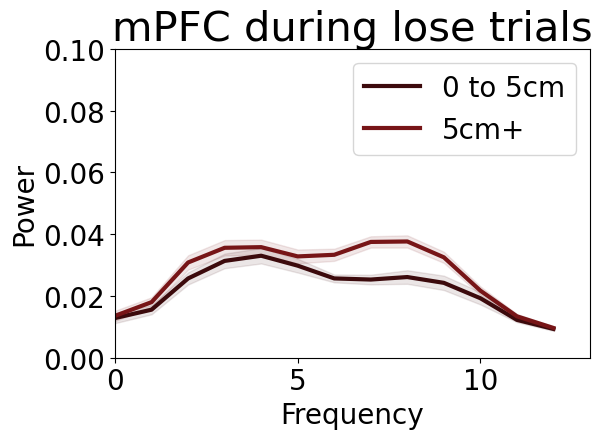

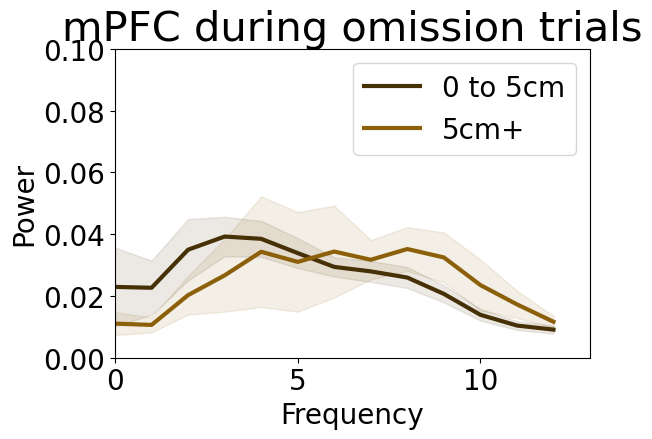

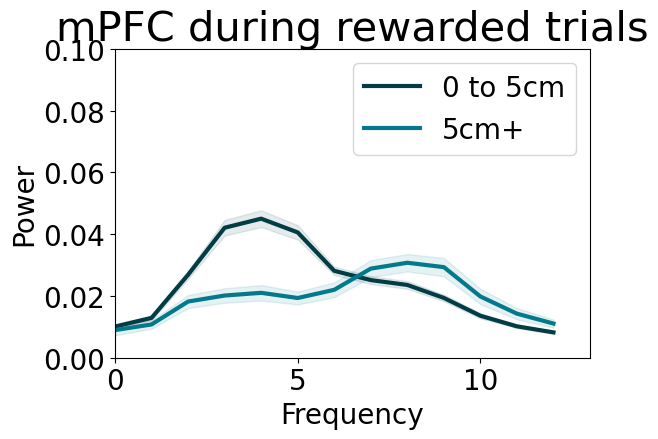

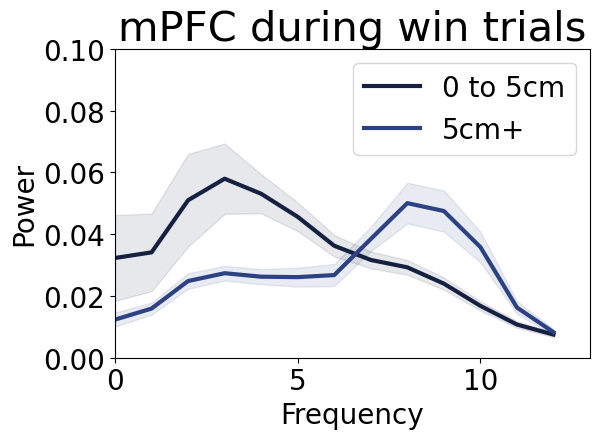

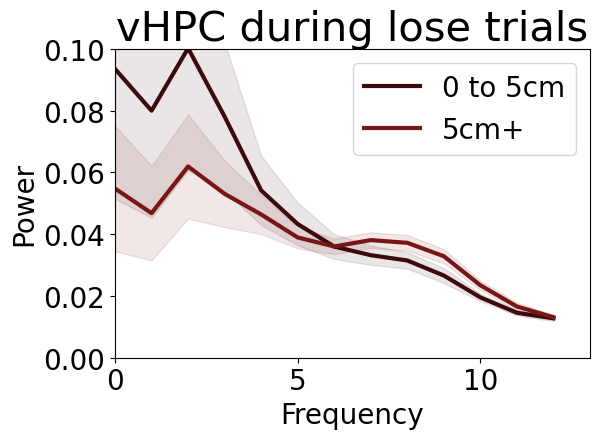

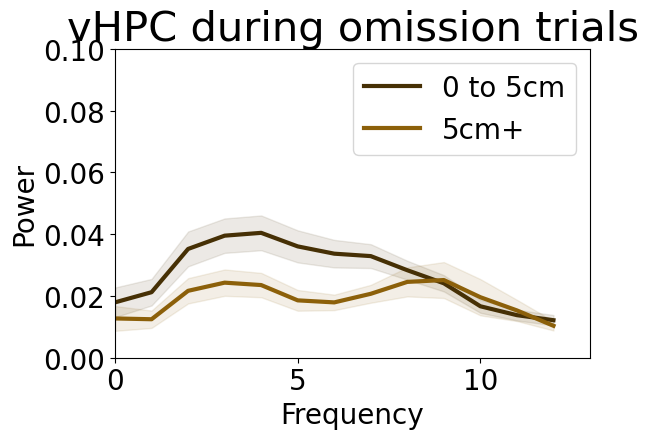

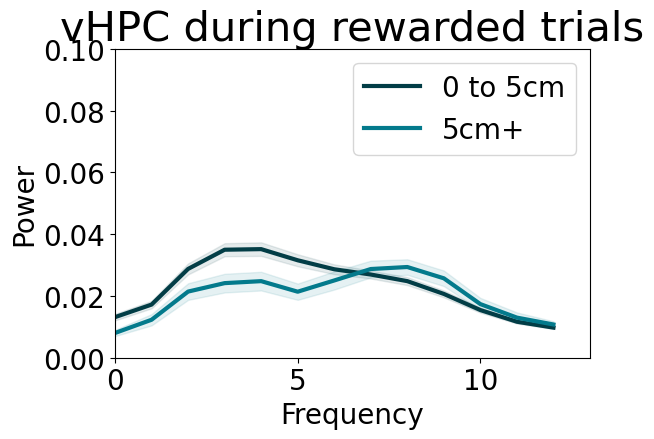

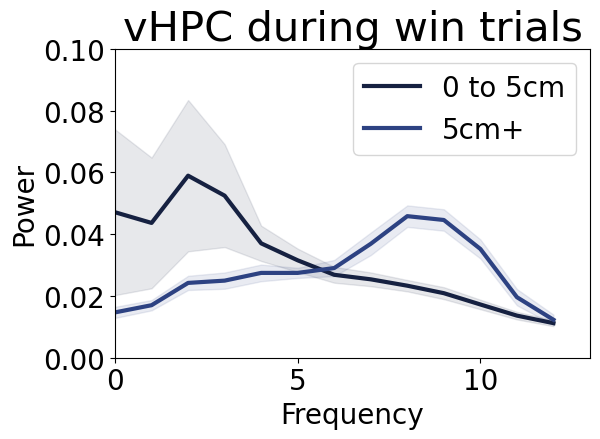

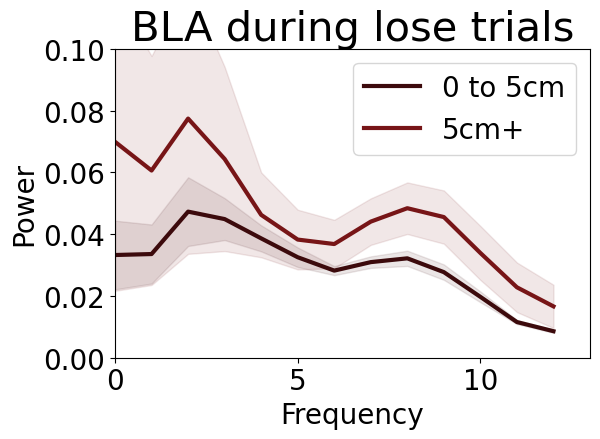

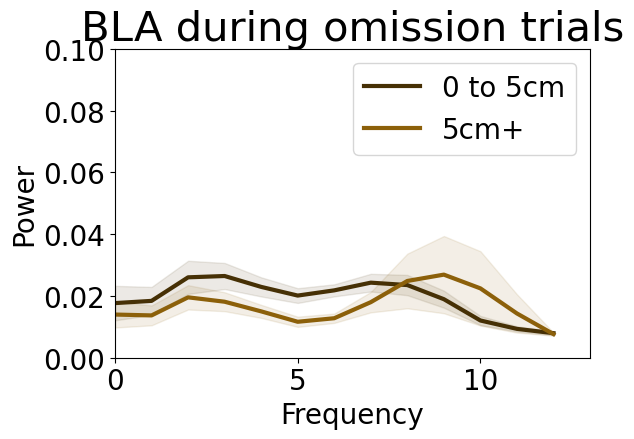

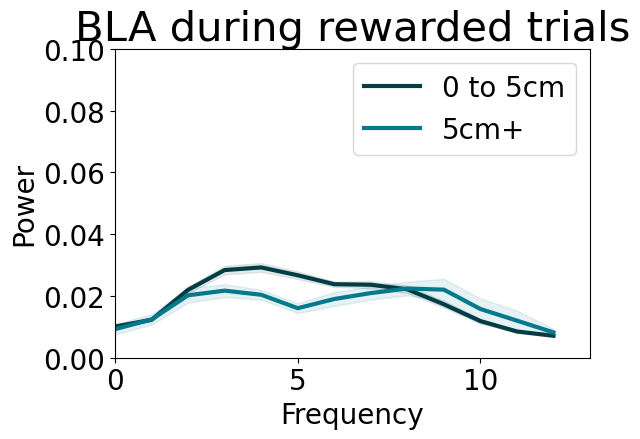

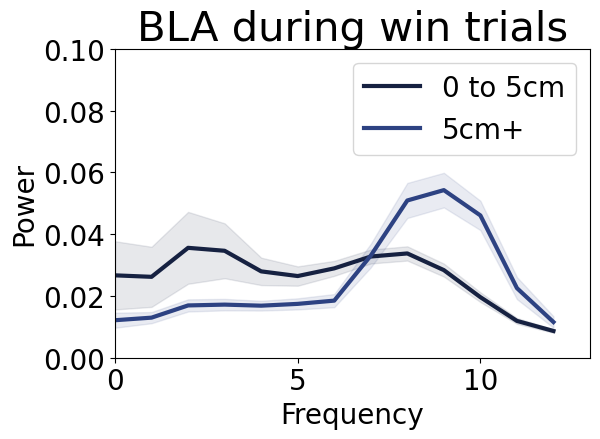

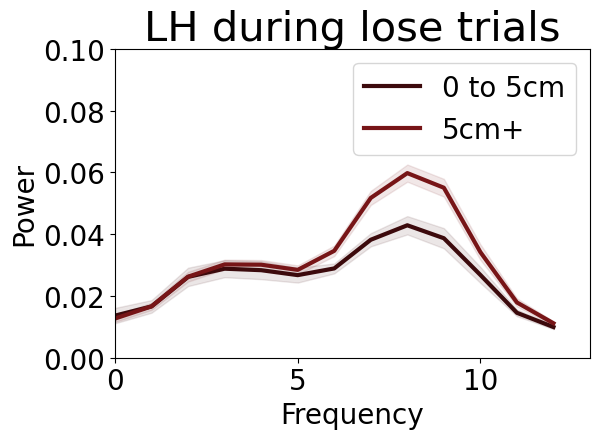

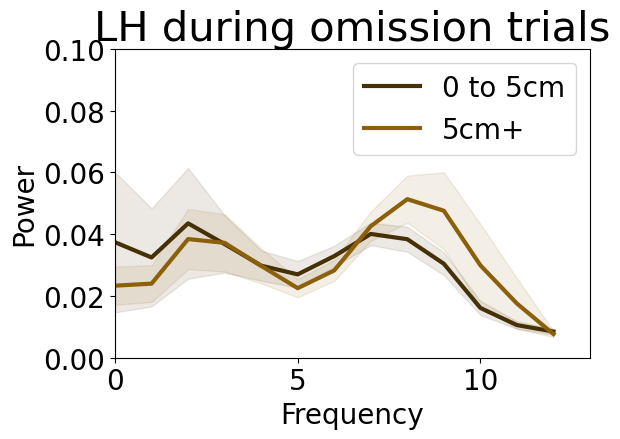

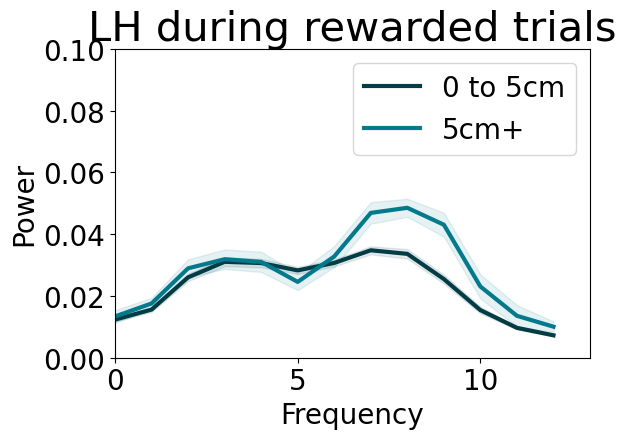

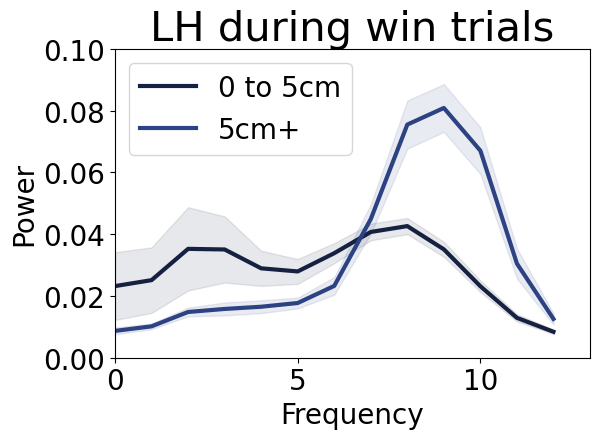

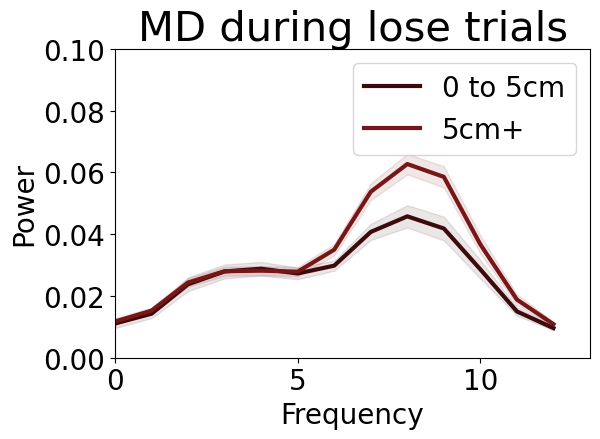

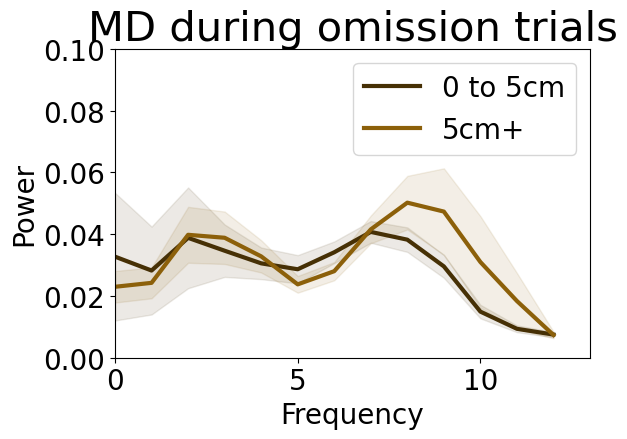

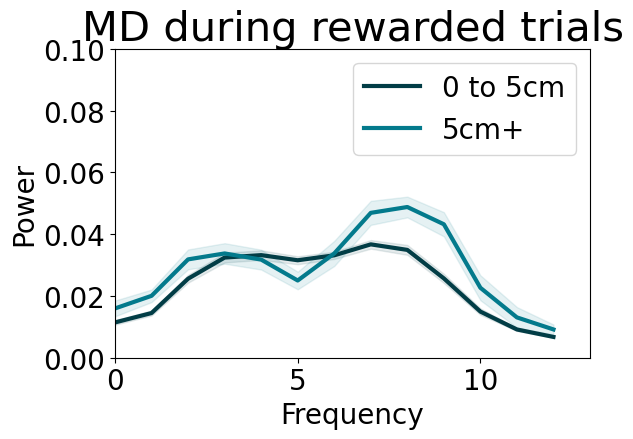

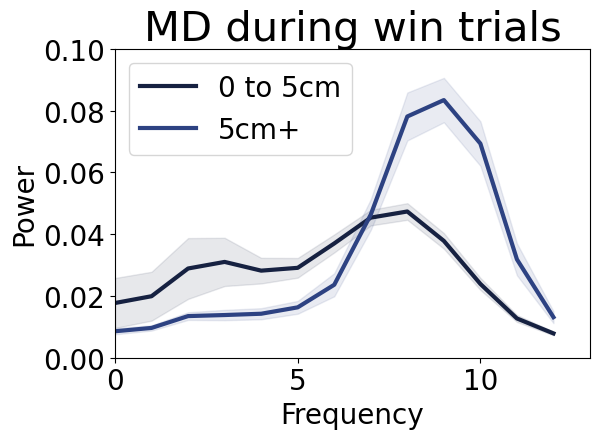

In [75]:
low_freq = 0
high_freq = 13
for region in grouped_all_trials_df["region_and_baseline_or_trial"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["region_and_baseline_or_trial"] == region]

    for outcome in region_df["trial_outcome"].unique():
        fig, ax = plt.subplots()
        plt.title("{} during {} trials".format(region.split("_")[0], outcome), fontsize=30)
        plt.xlabel("Frequency", fontsize=20)
        plt.ylabel("Power", fontsize=20)
        plt.xlim(low_freq, high_freq) 
        # plt.yscale("log")
        plt.ylim(0, 0.1)
        outcome_df = region_df[(region_df["trial_outcome"] == outcome)]
        # Generate gradient colors
        gradient_colors = generate_gradient_colors(OUTCOME_TO_COLOR[outcome], 20)
        
        for index, row in outcome_df.iterrows():           
            current_frequencies = ALL_FREQUENCIES[low_freq: high_freq]
            mean_power = row["mean_power"][low_freq: high_freq]
            sem_power = row["sem_power"][low_freq: high_freq]
                
            
            try:
                ax = sns.lineplot(x=current_frequencies, y=mean_power, \
                label="{}".format(BIN_TO_DISTANCE[row["distance_bin"]]), linewidth=3, color=gradient_colors[-(row["distance_bin"]+1) *4])
                
                plt.fill_between(current_frequencies, 
                mean_power - sem_power, mean_power + sem_power, \
                alpha=0.1, color=gradient_colors[-(row["distance_bin"]+1) *4])
            
            except Exception as e: 
                print(e)
                continue
                
        plt.legend()
        plt.tight_layout()
        plt.savefig("./proc/distance_parsed_power/rce_distance_parsed_lfp_power_freq_{}_to_{}_region_{}_{}.png".format(low_freq, high_freq, region.split("_")[0], outcome))

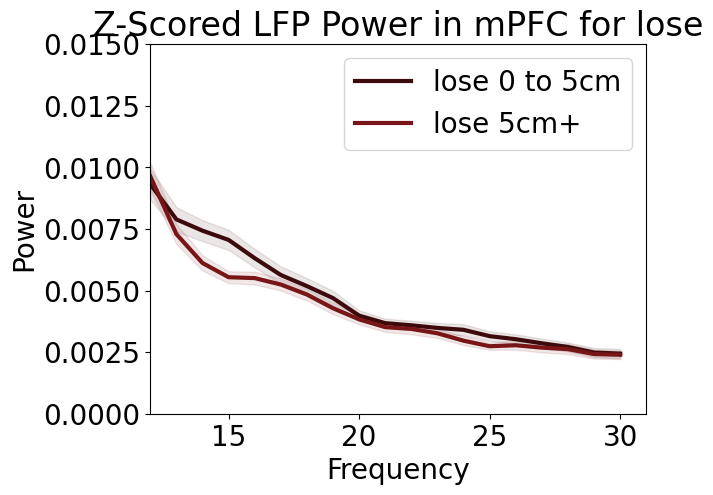

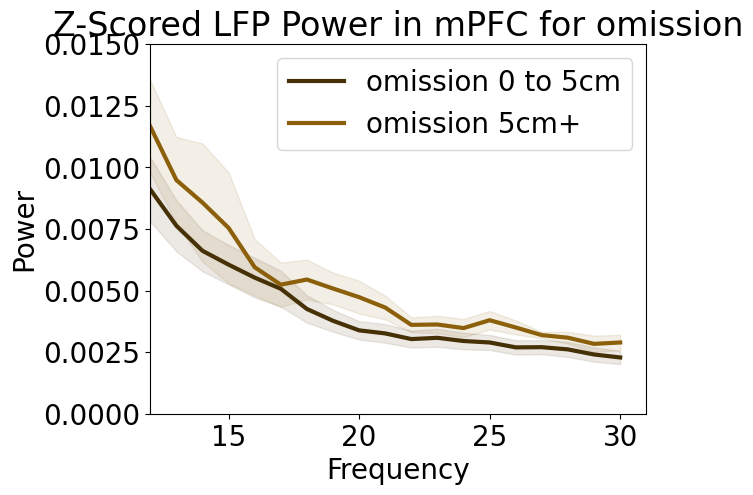

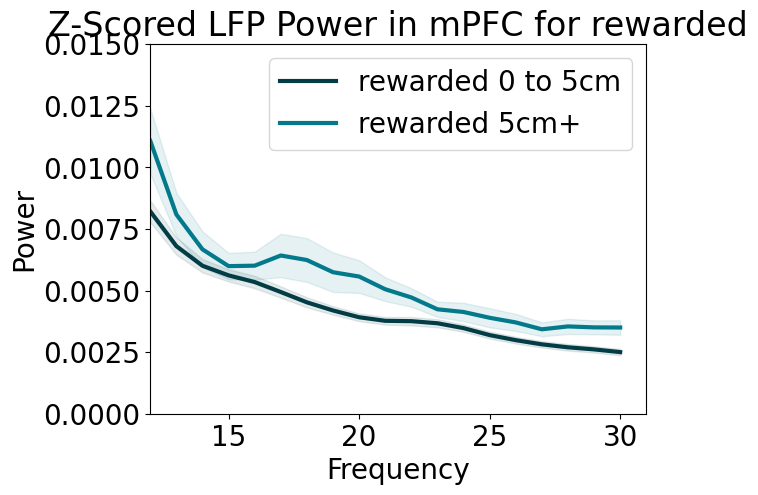

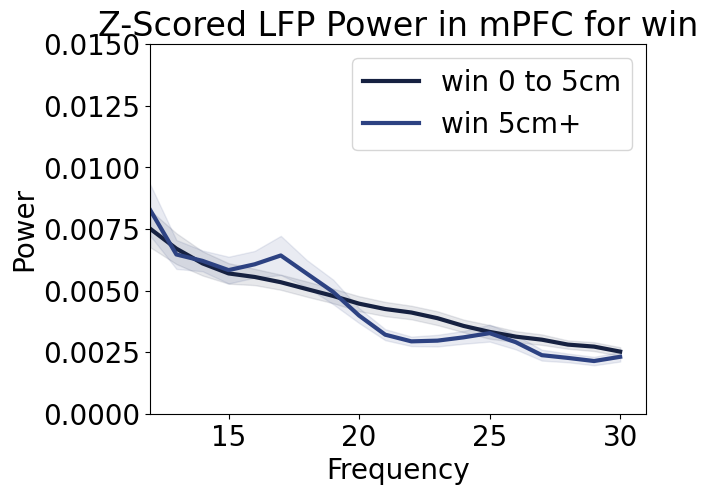

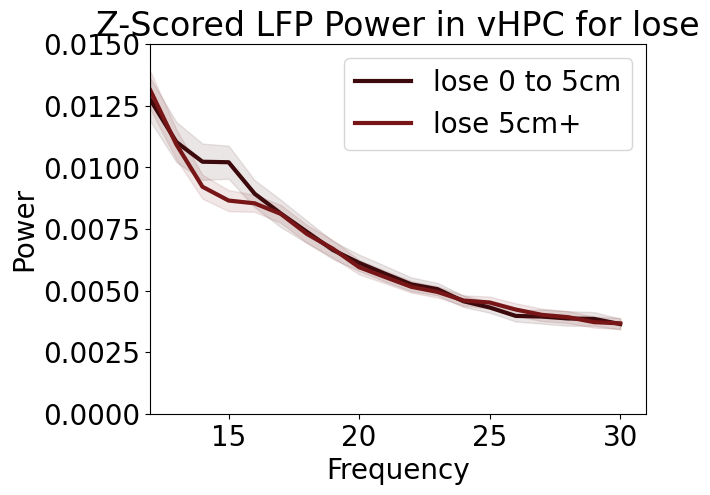

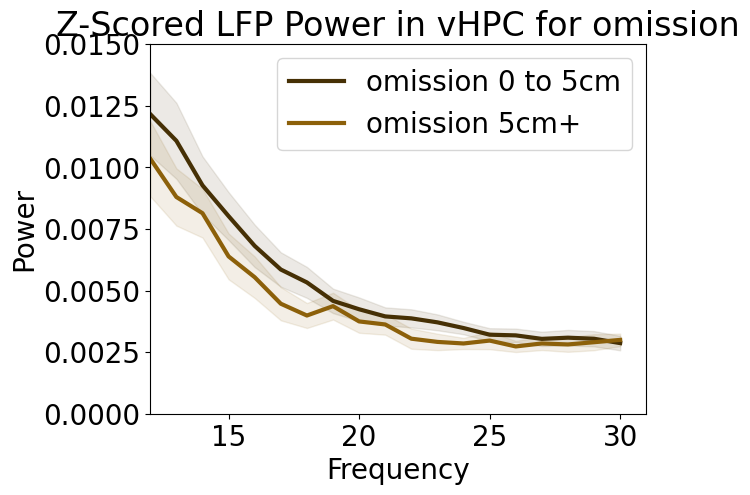

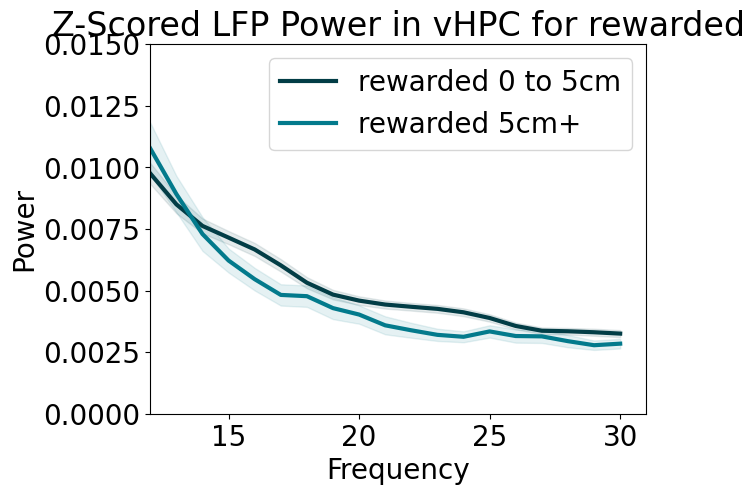

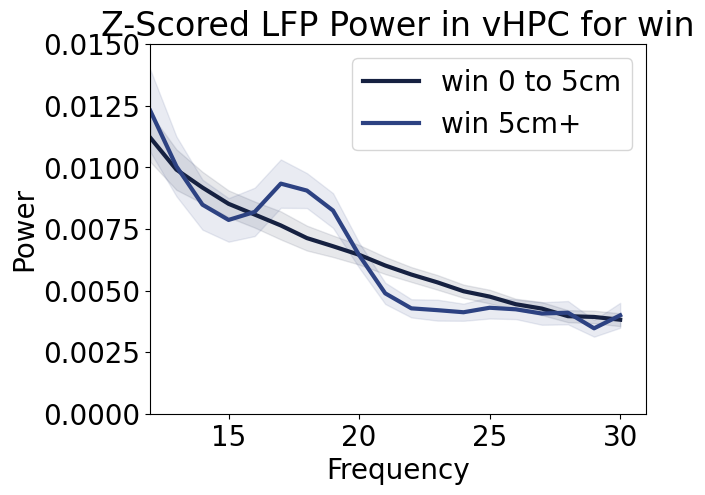

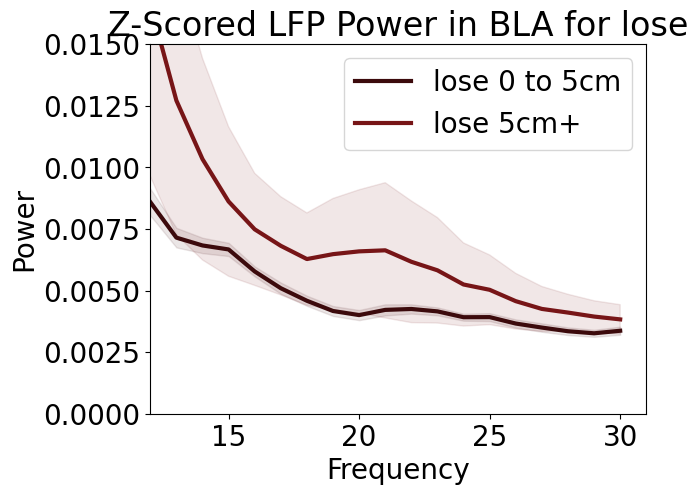

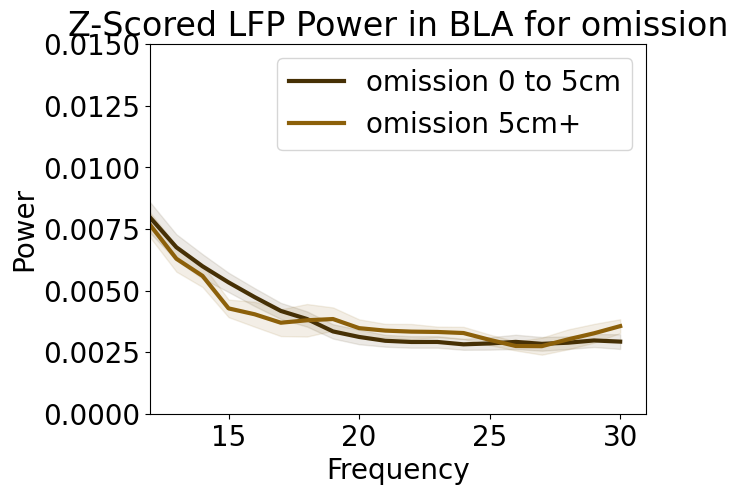

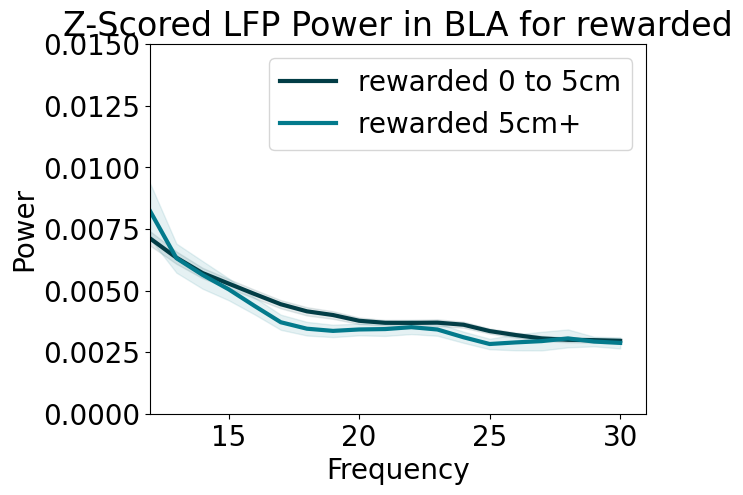

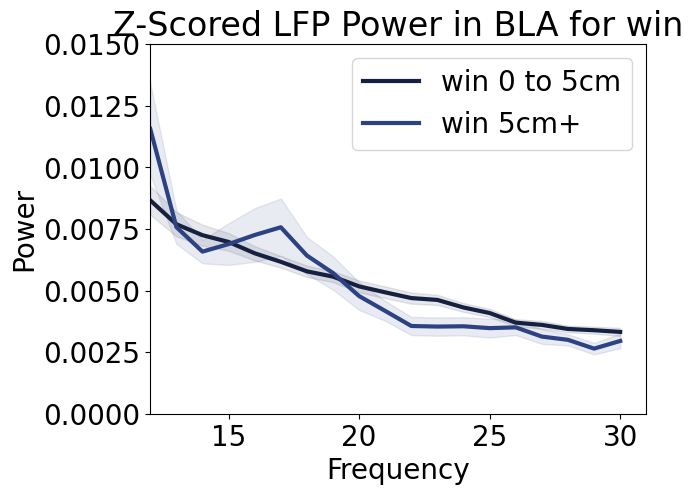

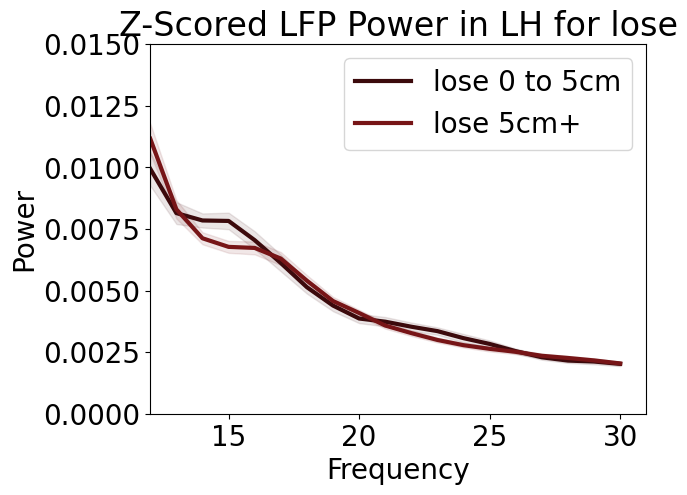

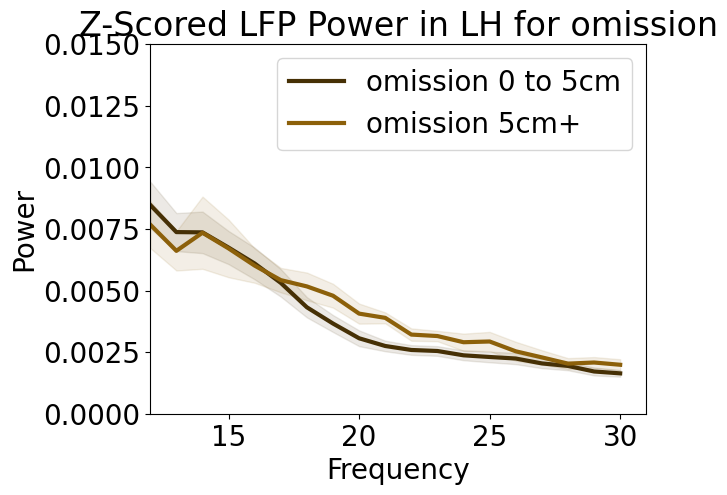

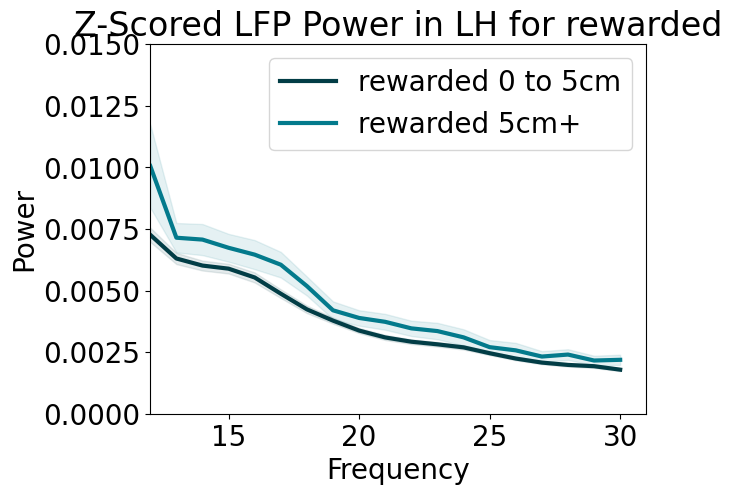

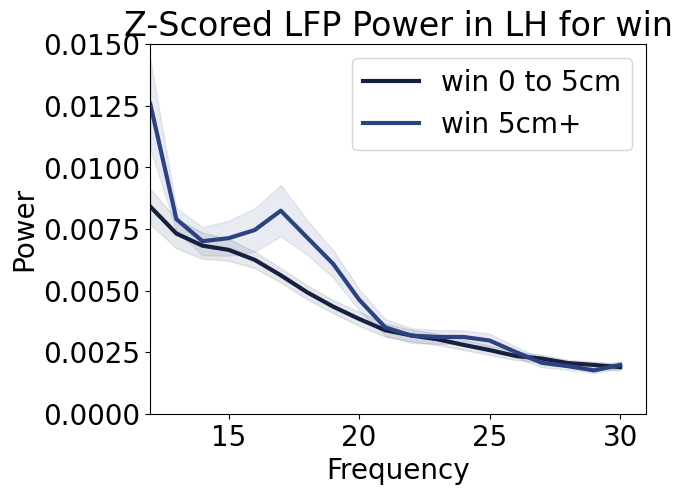

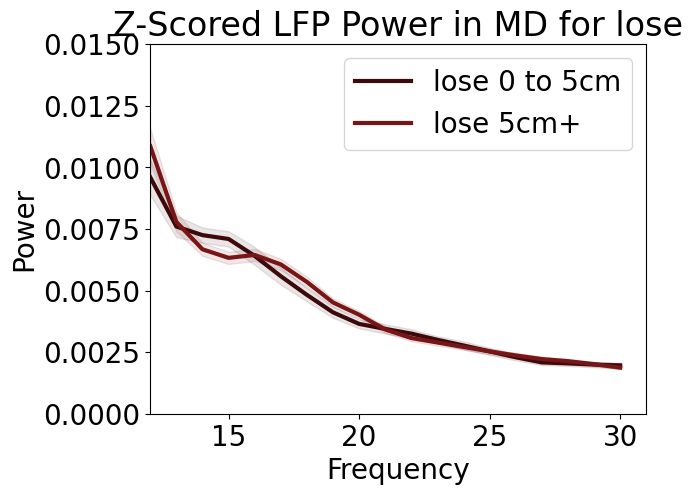

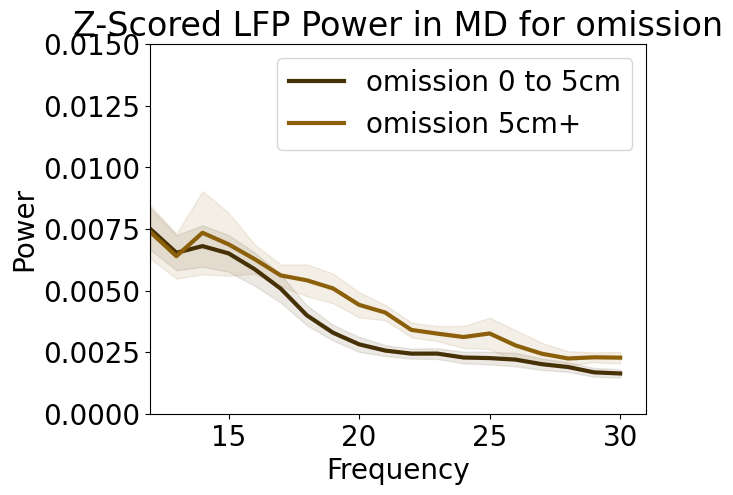

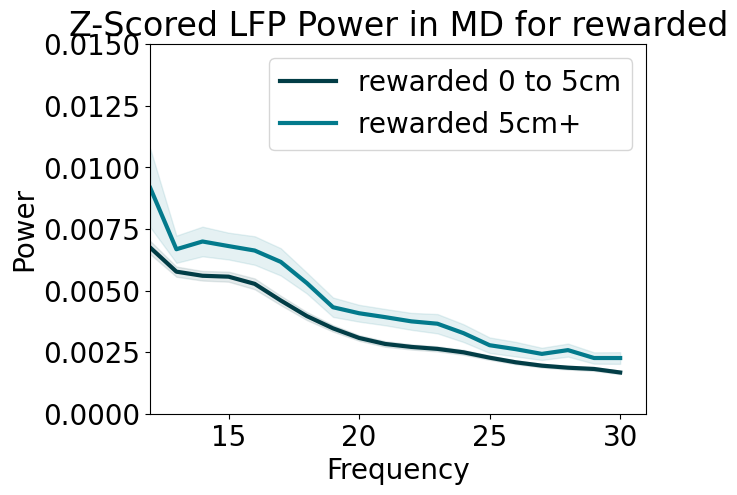

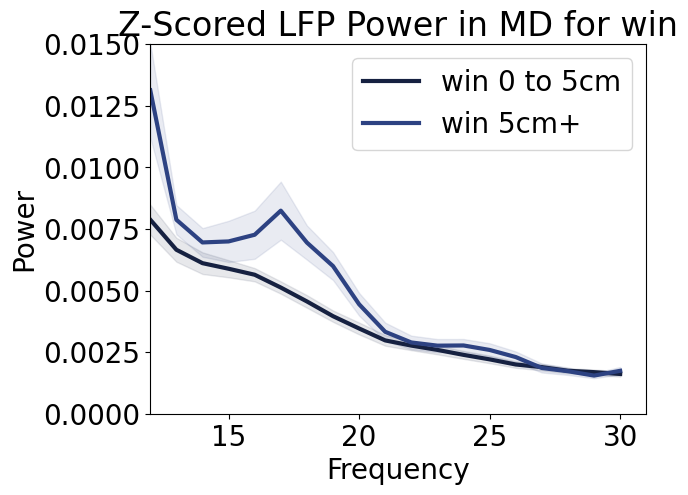

In [76]:
low_freq = 12
high_freq = 31
for region in grouped_all_trials_df["region_and_baseline_or_trial"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["region_and_baseline_or_trial"] == region]

    for outcome in region_df["trial_outcome"].unique():
        fig, ax = plt.subplots()
        plt.title("Z-Scored LFP Power in {} for {}".format(region.split("_")[0], outcome))
        plt.xlabel("Frequency")
        plt.ylabel("Power")
        plt.xlim(low_freq, high_freq) 
        # plt.yscale("log")
        plt.ylim(0, 0.015)
        
        outcome_df = region_df[(region_df["trial_outcome"] == outcome)]
        # Generate gradient colors
        gradient_colors = generate_gradient_colors(OUTCOME_TO_COLOR[outcome], 20)
        
        for index, row in outcome_df.iterrows():           
            current_frequencies = ALL_FREQUENCIES[low_freq: high_freq]
            mean_power = row["mean_power"][low_freq: high_freq]
            sem_power = row["sem_power"][low_freq: high_freq]
                
            
            try:
                ax = sns.lineplot(x=current_frequencies, y=mean_power, \
                label="{} {}".format(outcome, BIN_TO_DISTANCE[row["distance_bin"]]), linewidth=3, color=gradient_colors[-(row["distance_bin"]+1) *4])
                
                plt.fill_between(current_frequencies, 
                mean_power - sem_power, mean_power + sem_power, \
                alpha=0.1, color=gradient_colors[-(row["distance_bin"]+1) *4])
            
            except Exception as e: 
                print(e)
                continue
        plt.legend()
        plt.savefig("./proc/distance_parsed_power/rce_distance_parsed_lfp_power_freq_{}_to_{}_region_{}_{}.png".format(low_freq, high_freq, region.split("_")[0], outcome))

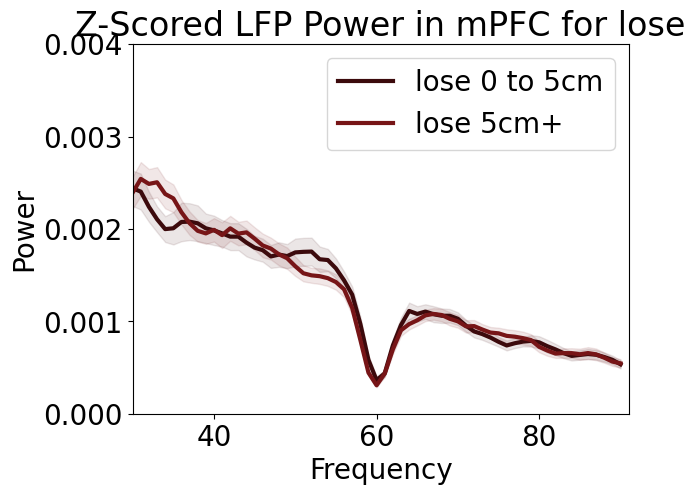

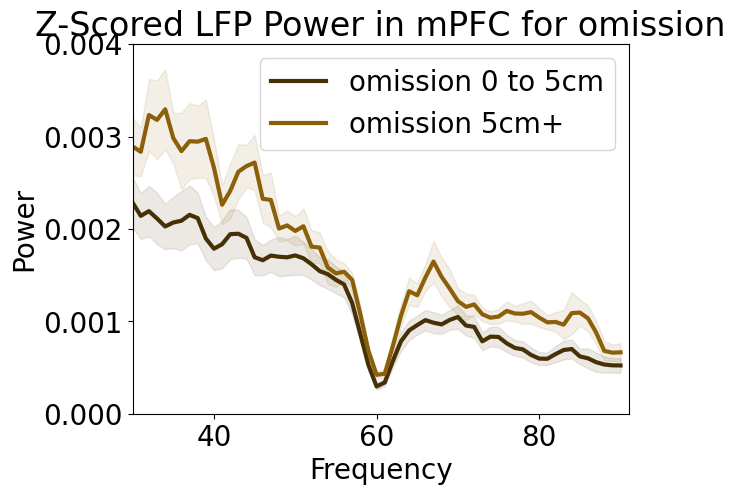

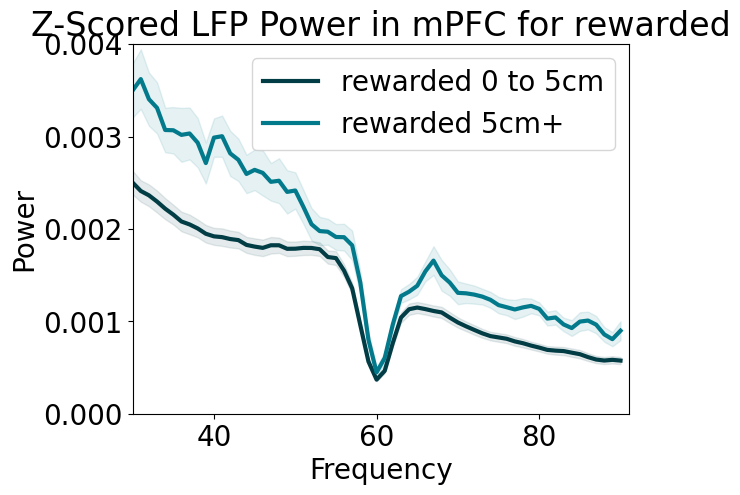

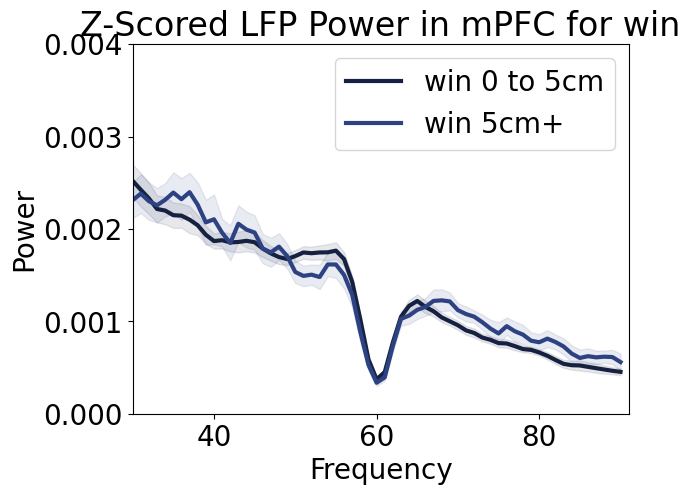

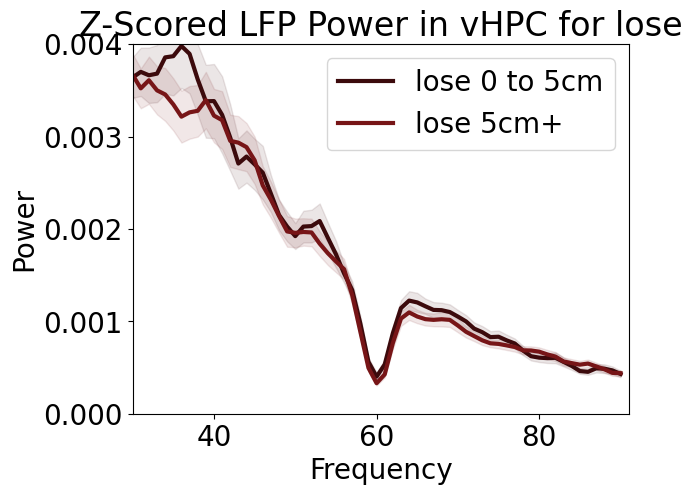

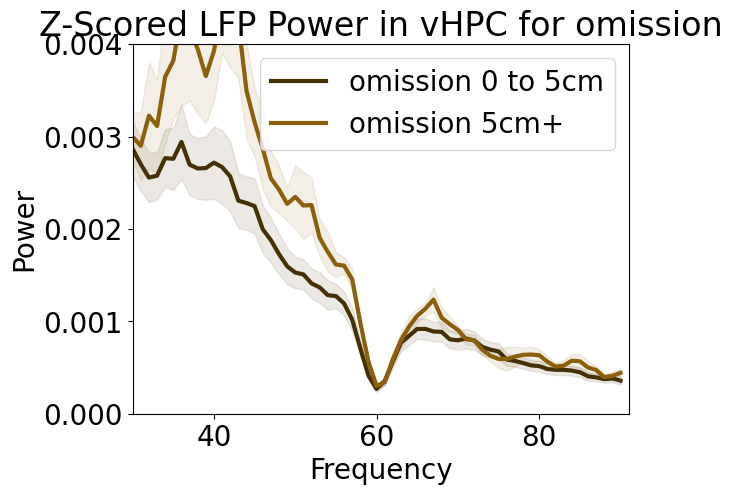

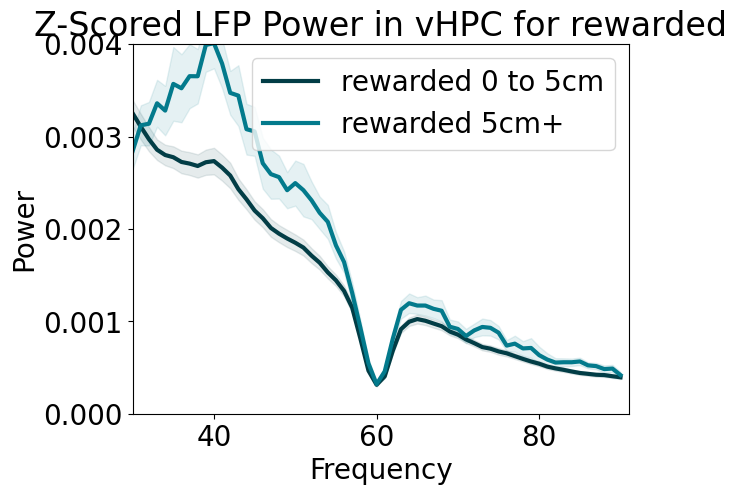

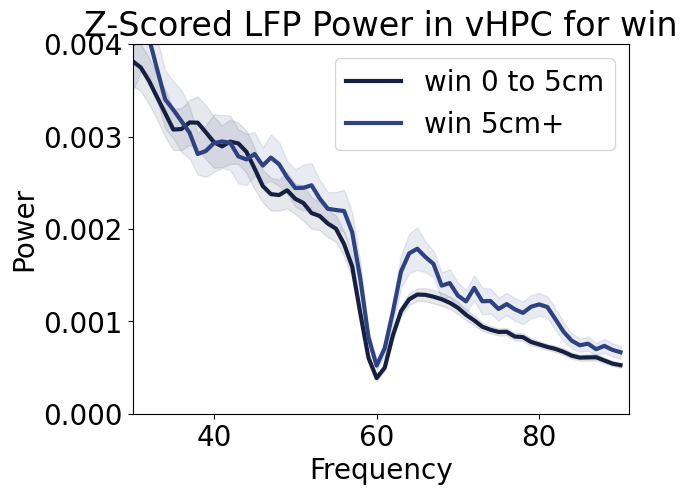

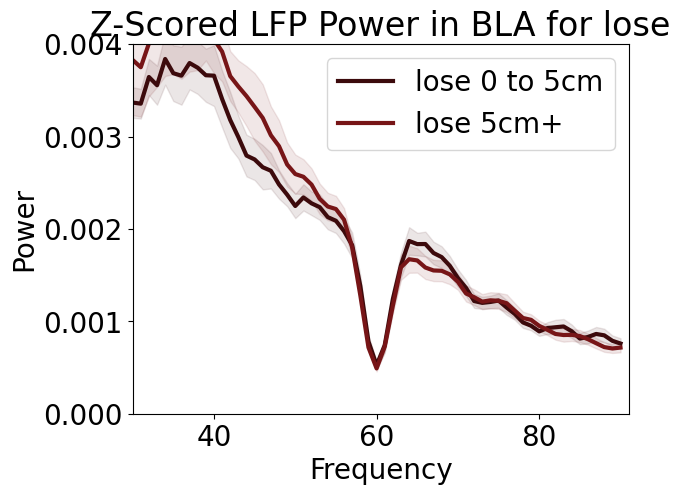

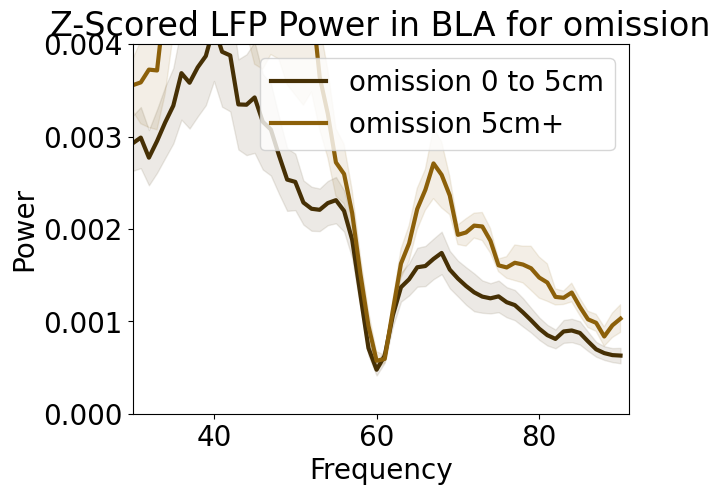

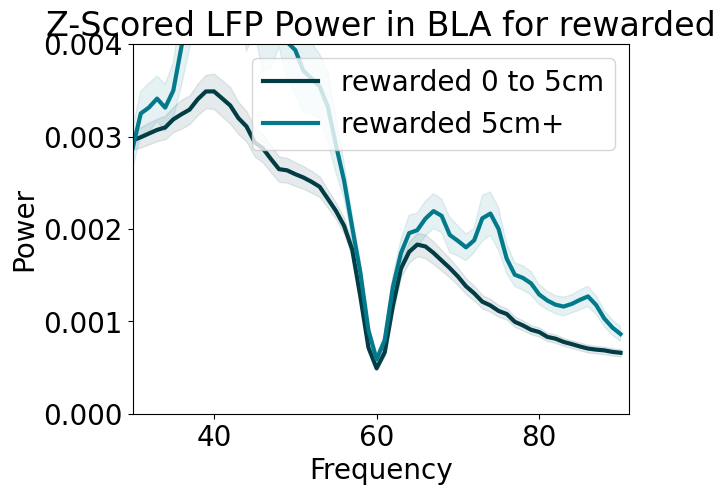

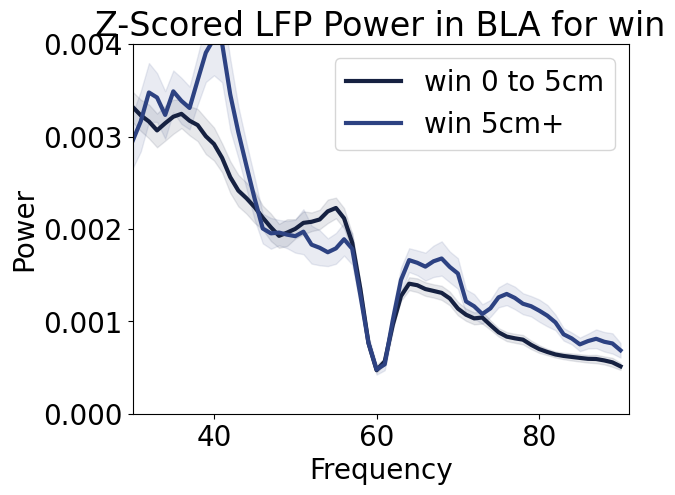

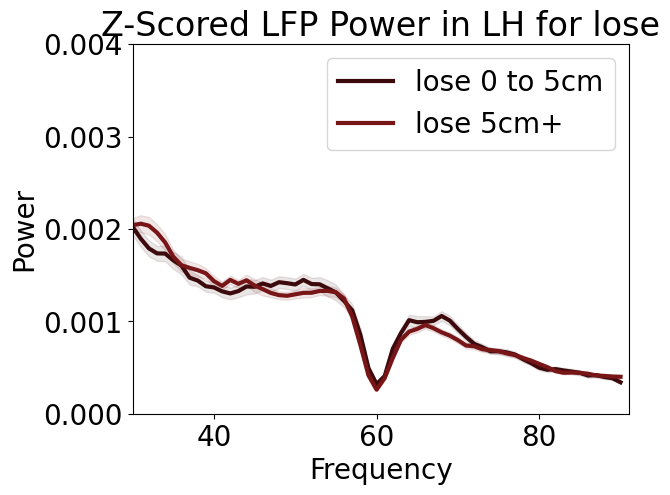

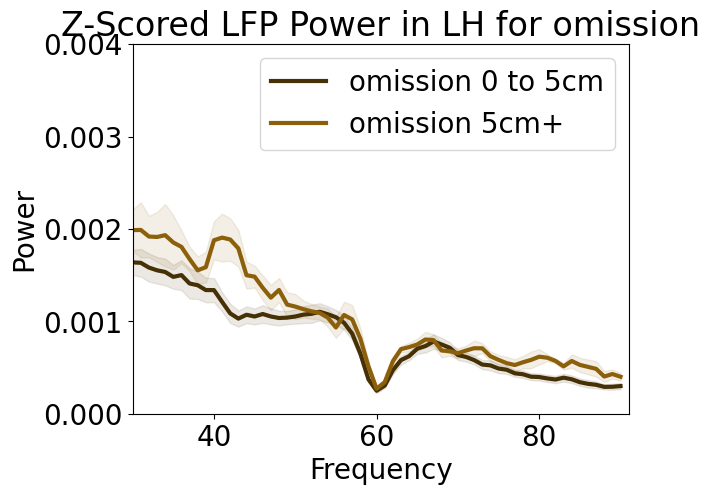

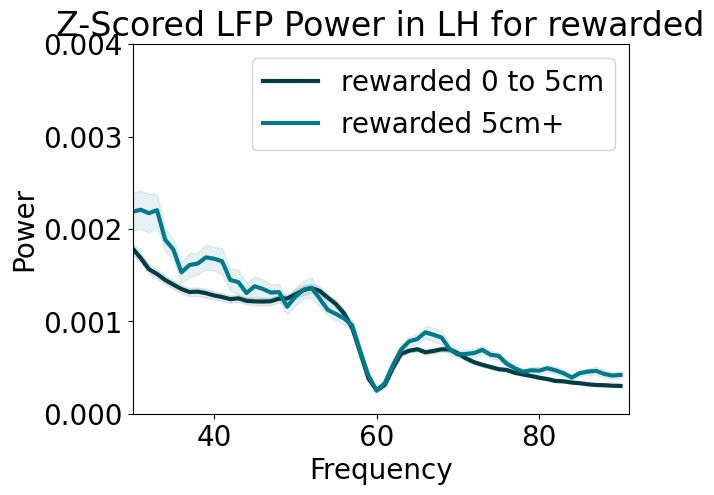

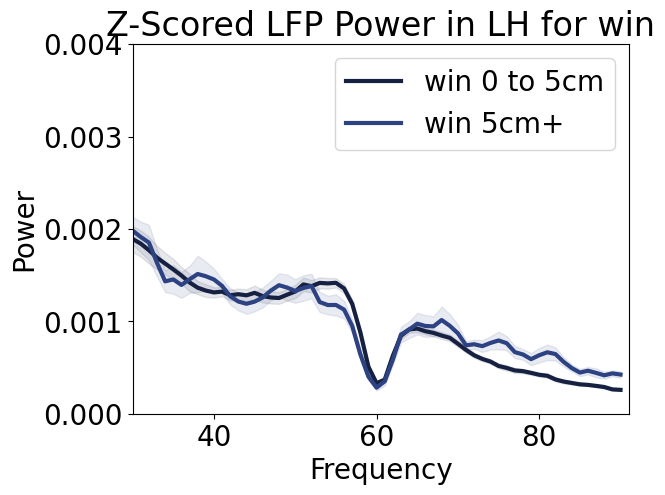

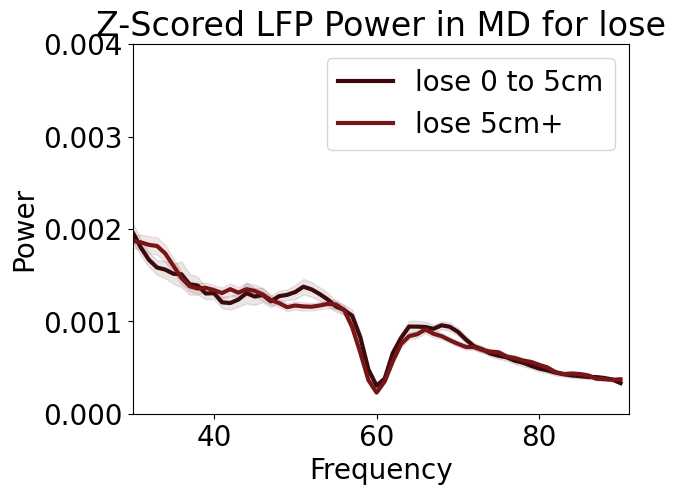

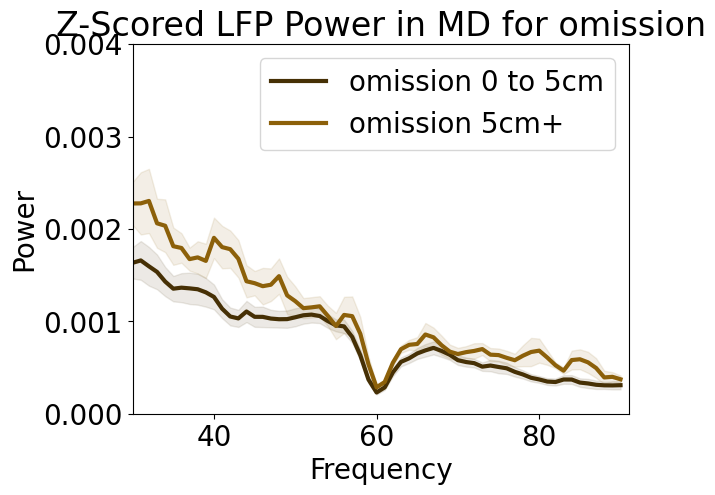

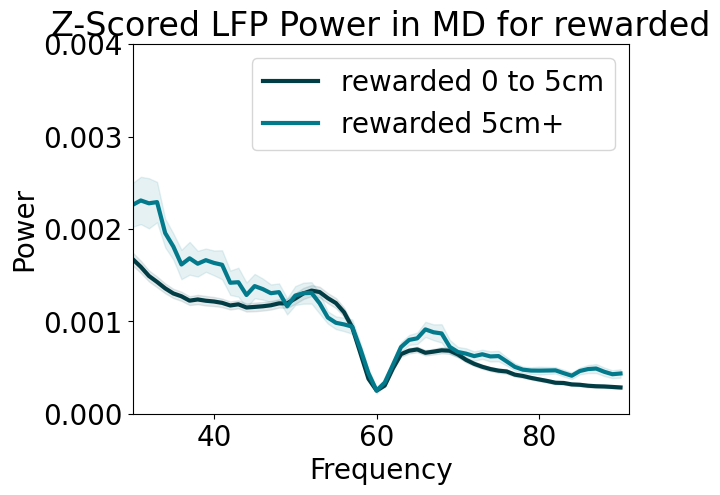

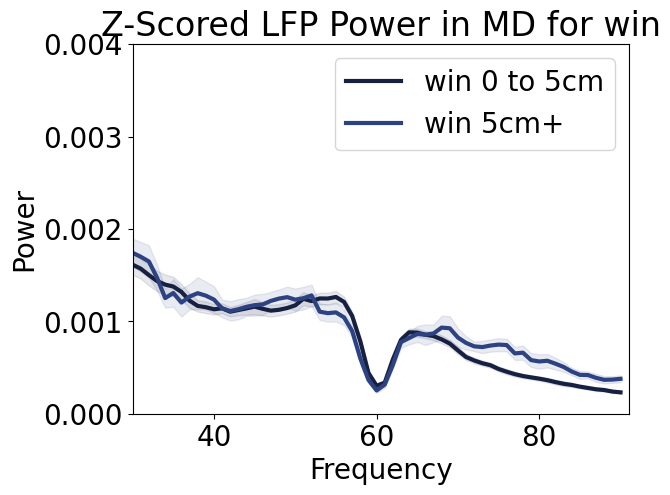

In [77]:
low_freq = 30
high_freq = 91
for region in grouped_all_trials_df["region_and_baseline_or_trial"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["region_and_baseline_or_trial"] == region]

    for outcome in region_df["trial_outcome"].unique():
        fig, ax = plt.subplots()
        plt.title("Z-Scored LFP Power in {} for {}".format(region.split("_")[0], outcome))
        plt.xlabel("Frequency")
        plt.ylabel("Power")
        plt.xlim(low_freq, high_freq) 
        # plt.yscale("log")
        plt.ylim(0, 0.004)
        outcome_df = region_df[(region_df["trial_outcome"] == outcome)]
        # Generate gradient colors
        gradient_colors = generate_gradient_colors(OUTCOME_TO_COLOR[outcome], 20)
        
        for index, row in outcome_df.iterrows():           
            current_frequencies = ALL_FREQUENCIES[low_freq: high_freq]
            mean_power = row["mean_power"][low_freq: high_freq]
            sem_power = row["sem_power"][low_freq: high_freq]
                
            
            try:
                ax = sns.lineplot(x=current_frequencies, y=mean_power, \
                label="{} {}".format(outcome, BIN_TO_DISTANCE[row["distance_bin"]]), linewidth=3, color=gradient_colors[-(row["distance_bin"]+1) *4])
                
                plt.fill_between(current_frequencies, 
                mean_power - sem_power, mean_power + sem_power, \
                alpha=0.1, color=gradient_colors[-(row["distance_bin"]+1) *4])
            
            except Exception as e: 
                print(e)
                continue
        plt.legend()
        plt.savefig("./proc/distance_parsed_power/rce_distance_parsed_lfp_power_freq_{}_to_{}_region_{}_{}.png".format(low_freq, high_freq, region.split("_")[0], outcome))

# Plotting be distance

In [78]:
grouped_all_trials_df = DISTANCE_PARSED_MERGED_LFP_AND_SLEAP.groupby(['distance_bin']).agg({k: lambda x: np.vstack([arr for arr in x.tolist() if not np.any(np.isnan(arr))]) for k in window_averaged_power_columns}).reset_index()

In [79]:
grouped_all_trials_df = pd.melt(grouped_all_trials_df, id_vars =['distance_bin'], value_vars =grouped_all_trials_df.drop(columns=["distance_bin"]).columns, value_name="power", var_name="region_and_baseline_or_trial") 

In [80]:
grouped_all_trials_df.head()

distance_bin                       region_and_baseline_or_trial  \
0             0  mPFC_baseline_distance_parsed_window_averaged_...   
1             1  mPFC_baseline_distance_parsed_window_averaged_...   
2             0  vHPC_baseline_distance_parsed_window_averaged_...   
3             1  vHPC_baseline_distance_parsed_window_averaged_...   
4             0  BLA_baseline_distance_parsed_window_averaged_p...   

                                               power  
0  [[0.003349504797072138, 0.011918596681862672, ...  
1  [[0.011947254289697694, 0.011967486126203276, ...  
2  [[0.004790114037220284, 0.009666746533909415, ...  
3  [[0.011293281173655943, 0.014189966170968153, ...  
4  [[0.0028941260405965547, 0.005902176491709042,...

In [81]:
grouped_all_trials_df["brain_region"] = grouped_all_trials_df["region_and_baseline_or_trial"].apply(lambda x: x.split("_")[0].strip())

In [82]:
grouped_all_trials_df["trial_or_baseline"] = grouped_all_trials_df["region_and_baseline_or_trial"].apply(lambda x: x.split("_")[1].strip())

In [83]:
grouped_all_trials_df["mean_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanmean(np.vstack(x), axis=0))

In [84]:
grouped_all_trials_df["std_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanstd(np.vstack(x), axis=0))

In [85]:
grouped_all_trials_df["n_trials"] = grouped_all_trials_df["power"].apply(lambda x: np.sum(~np.isnan(x), axis=0))

In [86]:
grouped_all_trials_df["sem_power"] = grouped_all_trials_df.apply(lambda x: x["std_power"] / np.sqrt(x["n_trials"]), axis=1)

In [87]:
grouped_all_trials_df.head()

distance_bin                       region_and_baseline_or_trial  \
0             0  mPFC_baseline_distance_parsed_window_averaged_...   
1             1  mPFC_baseline_distance_parsed_window_averaged_...   
2             0  vHPC_baseline_distance_parsed_window_averaged_...   
3             1  vHPC_baseline_distance_parsed_window_averaged_...   
4             0  BLA_baseline_distance_parsed_window_averaged_p...   

                                               power brain_region  \
0  [[0.003349504797072138, 0.011918596681862672, ...         mPFC   
1  [[0.011947254289697694, 0.011967486126203276, ...         mPFC   
2  [[0.004790114037220284, 0.009666746533909415, ...         vHPC   
3  [[0.011293281173655943, 0.014189966170968153, ...         vHPC   
4  [[0.0028941260405965547, 0.005902176491709042,...          BLA   

  trial_or_baseline                                         mean_power  \
0          baseline  [0.01743535859737272, 0.020249621342059012, 0....   
1          baseline  [0.029716946031178793, 0.03149701031175347, 0....   
2          baseline  [0.02704152909935942, 0.03181268786157024, 0.0...   
3          baseline  [0.035382267125874965, 0.03450080314736335, 0....   
4          baseline  [0.016023376004549835, 0.018343295833643185, 0...   

                                           std_power  \
0  [0.052788538728824864, 0.04285147534760311, 0....   
1  [0.16780265891668533, 0.16170666245984866, 0.1...   
2  [0.08142752489797195, 0.09187404790753954, 0.1...   
3  [0.11501689901359338, 0.08734936879828417, 0.1...   
4  [0.032237436169429125, 0.030303389361675526, 0...   

                                            n_trials  \
0  [159, 159, 159, 159, 159, 159, 159, 159, 159, ...   
1  [111, 111, 111, 111, 111, 111, 111, 111, 111, ...   
2  [159, 159, 159, 159, 159, 159, 159, 159, 159, ...   
3  [111, 111, 111, 111, 111, 111, 111, 111, 111, ...   
4  [159, 159, 159, 159, 159, 159, 159, 159, 159, ...   

                                           sem_power  
0  [0.004186403434663822, 0.003398343047477861, 0...  
1  [0.015927123541930127, 0.015348517164021584, 0...  
2  [0.0064576227741440315, 0.007286085937941897, ...  
3  [0.010916920934540988, 0.008290835181882528, 0...  
4  [0.002556594987365322, 0.0024032150985911116, ...

# Drawing all distance bins together for each trial outcome

In [88]:
OUTCOME_TO_COLOR

{'lose': '#951a1d',
 'omission': '#af780d',
 'rewarded': '#0499af',
 'win': '#3853a3'}

In [89]:
grouped_all_trials_df.head()

distance_bin                       region_and_baseline_or_trial  \
0             0  mPFC_baseline_distance_parsed_window_averaged_...   
1             1  mPFC_baseline_distance_parsed_window_averaged_...   
2             0  vHPC_baseline_distance_parsed_window_averaged_...   
3             1  vHPC_baseline_distance_parsed_window_averaged_...   
4             0  BLA_baseline_distance_parsed_window_averaged_p...   

                                               power brain_region  \
0  [[0.003349504797072138, 0.011918596681862672, ...         mPFC   
1  [[0.011947254289697694, 0.011967486126203276, ...         mPFC   
2  [[0.004790114037220284, 0.009666746533909415, ...         vHPC   
3  [[0.011293281173655943, 0.014189966170968153, ...         vHPC   
4  [[0.0028941260405965547, 0.005902176491709042,...          BLA   

  trial_or_baseline                                         mean_power  \
0          baseline  [0.01743535859737272, 0.020249621342059012, 0....   
1          baseline  [0.029716946031178793, 0.03149701031175347, 0....   
2          baseline  [0.02704152909935942, 0.03181268786157024, 0.0...   
3          baseline  [0.035382267125874965, 0.03450080314736335, 0....   
4          baseline  [0.016023376004549835, 0.018343295833643185, 0...   

                                           std_power  \
0  [0.052788538728824864, 0.04285147534760311, 0....   
1  [0.16780265891668533, 0.16170666245984866, 0.1...   
2  [0.08142752489797195, 0.09187404790753954, 0.1...   
3  [0.11501689901359338, 0.08734936879828417, 0.1...   
4  [0.032237436169429125, 0.030303389361675526, 0...   

                                            n_trials  \
0  [159, 159, 159, 159, 159, 159, 159, 159, 159, ...   
1  [111, 111, 111, 111, 111, 111, 111, 111, 111, ...   
2  [159, 159, 159, 159, 159, 159, 159, 159, 159, ...   
3  [111, 111, 111, 111, 111, 111, 111, 111, 111, ...   
4  [159, 159, 159, 159, 159, 159, 159, 159, 159, ...   

                                           sem_power  
0  [0.004186403434663822, 0.003398343047477861, 0...  
1  [0.015927123541930127, 0.015348517164021584, 0...  
2  [0.0064576227741440315, 0.007286085937941897, ...  
3  [0.010916920934540988, 0.008290835181882528, 0...  
4  [0.002556594987365322, 0.0024032150985911116, ...

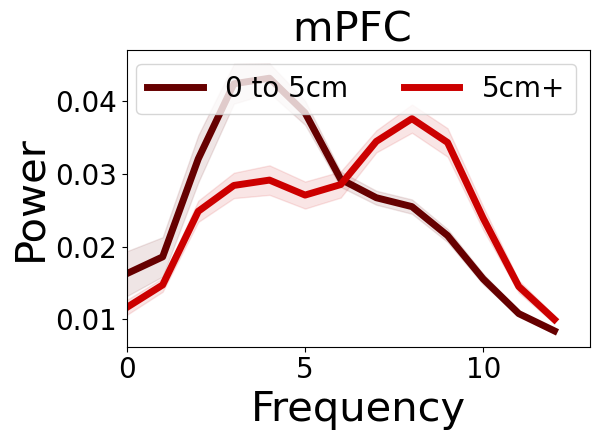

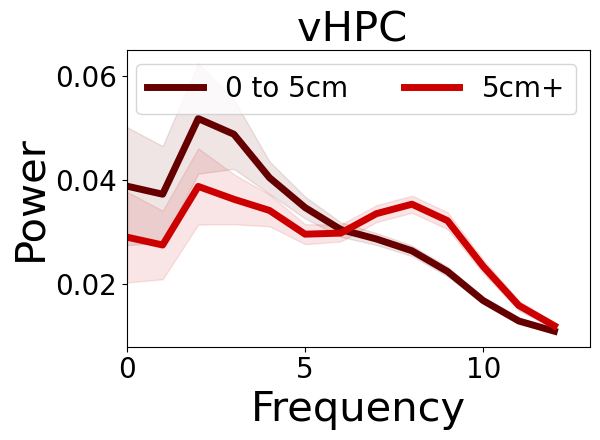

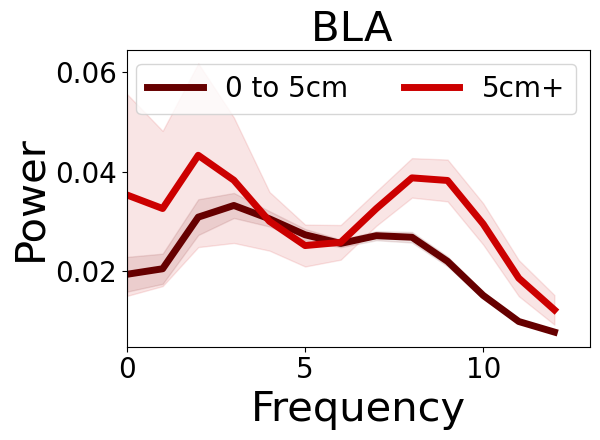

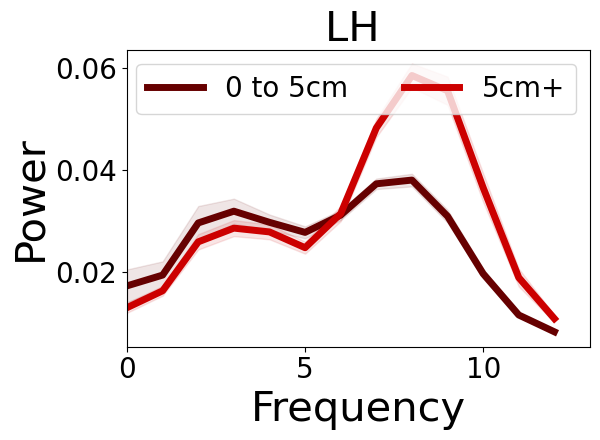

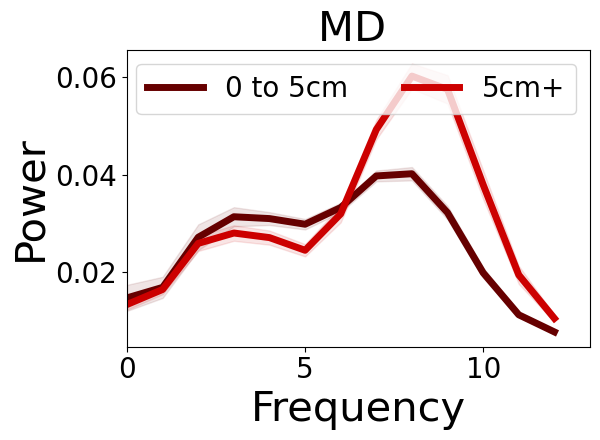

In [90]:
low_freq = 0
high_freq = 13
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[(grouped_all_trials_df["brain_region"] == region) & (grouped_all_trials_df["trial_or_baseline"] == "trial")]

    fig, ax = plt.subplots()
    plt.title("{} ".format(region.split("_")[0]), fontsize=30)
    plt.xlabel("Frequency", fontsize=30)
    plt.ylabel("Power", fontsize=30)
    plt.xlim(low_freq, high_freq) 
    # plt.yscale("log")
    
    # Generate gradient colors
    gradient_colors = generate_gradient_colors("red", 20)
    
    for index, row in region_df.iterrows():           

        current_frequencies = ALL_FREQUENCIES[low_freq: high_freq]
        mean_power = row["mean_power"][low_freq: high_freq]
        sem_power = row["sem_power"][low_freq: high_freq]
            
        
        try:
            ax = sns.lineplot(x=current_frequencies, y=mean_power, \
            label="{}".format(BIN_TO_DISTANCE[row["distance_bin"]]), linewidth=5, color=gradient_colors[-(row["distance_bin"]+1) *4])
            
            plt.fill_between(current_frequencies, 
            mean_power - sem_power, mean_power + sem_power, \
            alpha=0.1, color=gradient_colors[-(row["distance_bin"]+1) *4])
        
        except Exception as e: 
            print(e)
            continue
    plt.tight_layout()
    plt.legend(ncol=2)
    plt.savefig("./proc/distance_parsed_power/rce_distance_parsed_lfp_power_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[0]))

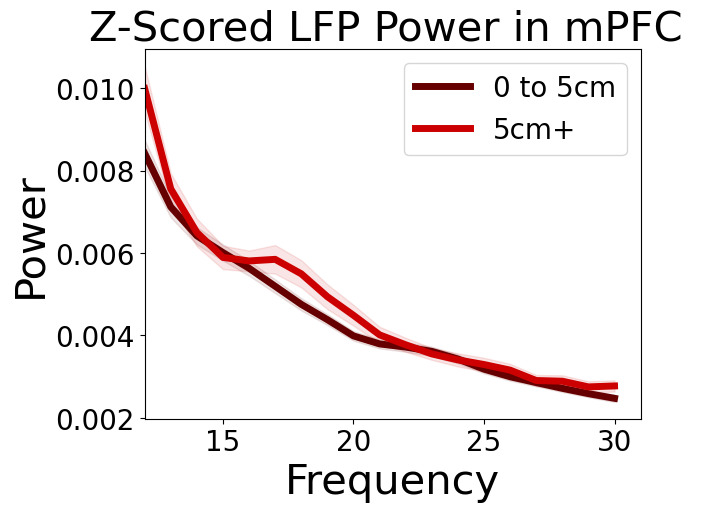

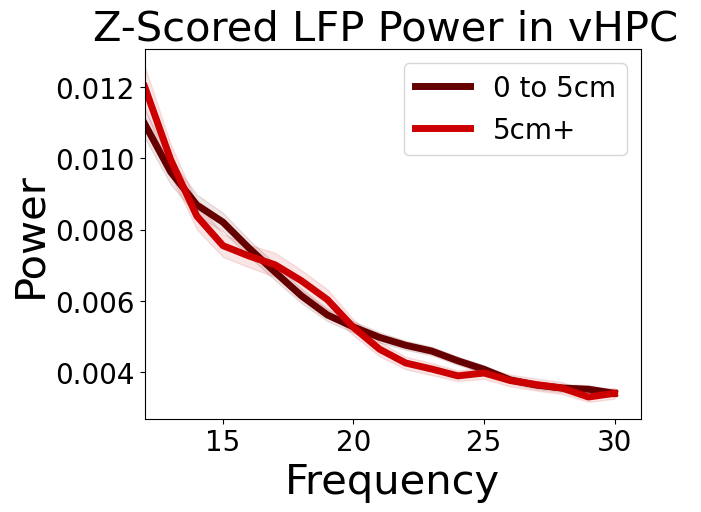

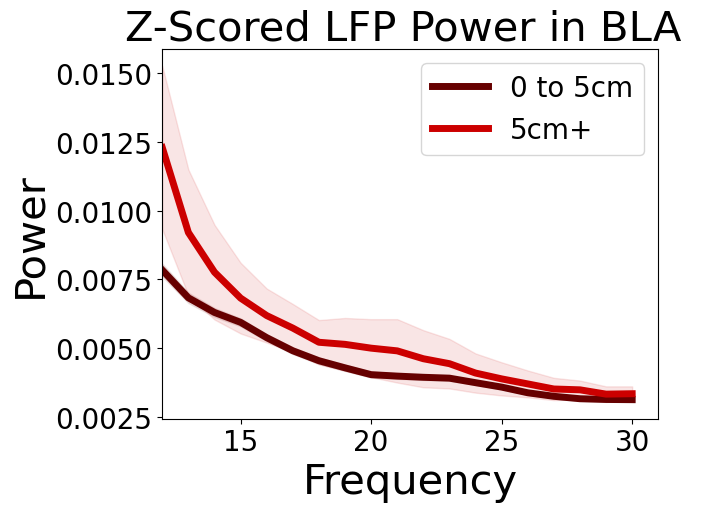

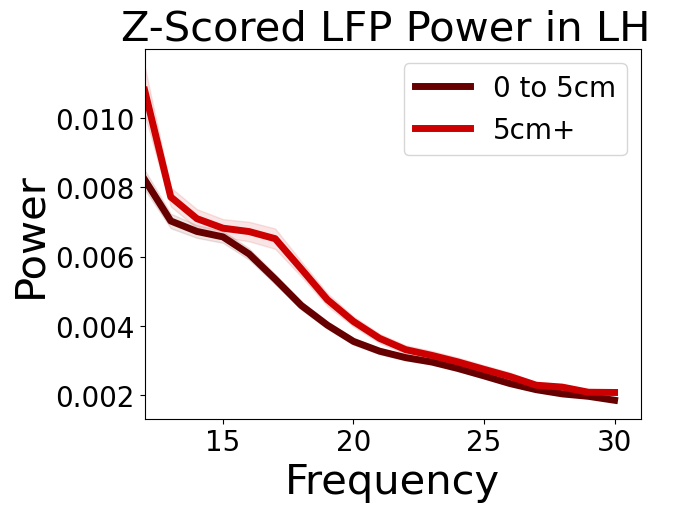

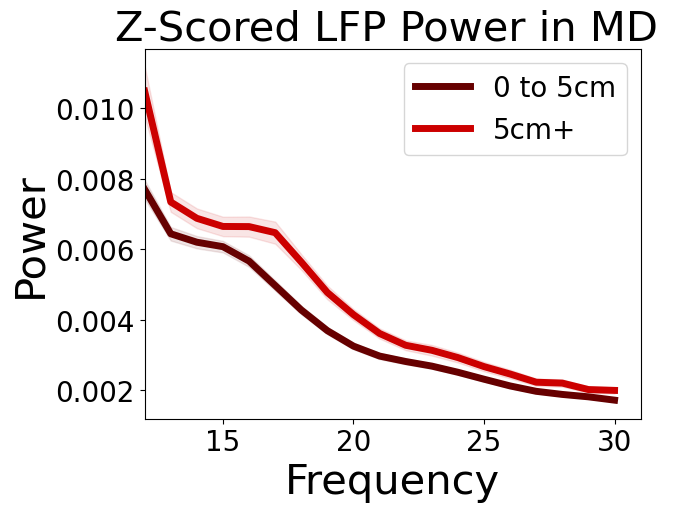

In [91]:
low_freq = 12
high_freq = 31
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[(grouped_all_trials_df["brain_region"] == region) & (grouped_all_trials_df["trial_or_baseline"] == "trial")]

    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {} ".format(region.split("_")[0]), fontsize=30)
    plt.xlabel("Frequency", fontsize=30)
    plt.ylabel("Power", fontsize=30)
    plt.xlim(low_freq, high_freq) 
    # plt.yscale("log")
    
    # Generate gradient colors
    gradient_colors = generate_gradient_colors("red", 20)
    
    for index, row in region_df.iterrows():           

        current_frequencies = ALL_FREQUENCIES[low_freq: high_freq]
        mean_power = row["mean_power"][low_freq: high_freq]
        sem_power = row["sem_power"][low_freq: high_freq]
            
        
        try:
            ax = sns.lineplot(x=current_frequencies, y=mean_power, \
            label="{}".format(BIN_TO_DISTANCE[row["distance_bin"]]), linewidth=5, color=gradient_colors[-(row["distance_bin"]+1) *4])
            
            plt.fill_between(current_frequencies, 
            mean_power - sem_power, mean_power + sem_power, \
            alpha=0.1, color=gradient_colors[-(row["distance_bin"]+1) *4])
        
        except Exception as e: 
            print(e)
            continue
    plt.legend()
    plt.savefig("./proc/distance_parsed_power/rce_distance_parsed_lfp_power_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[0]))

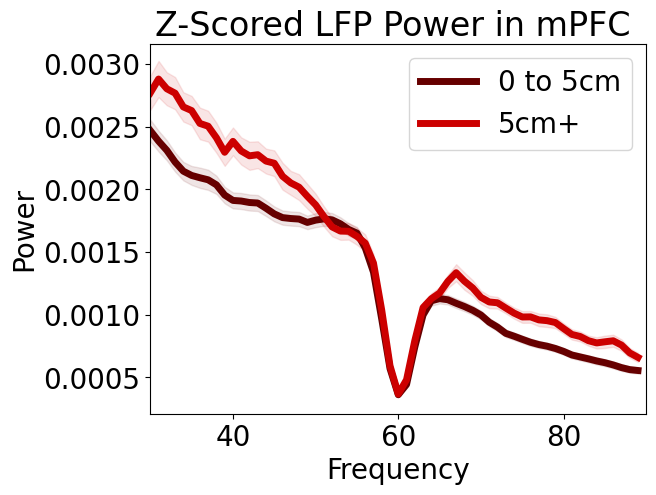

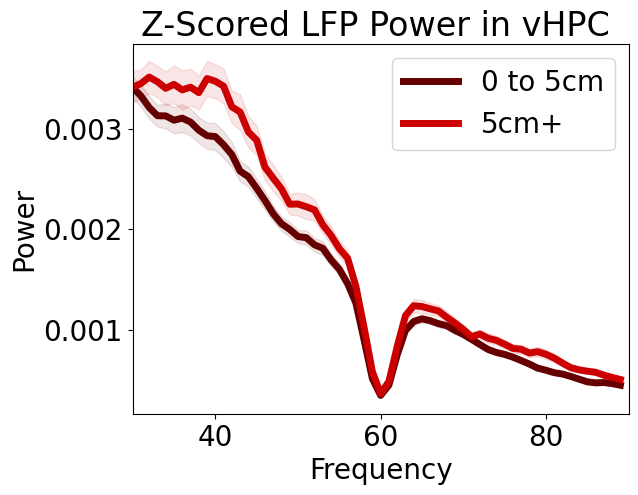

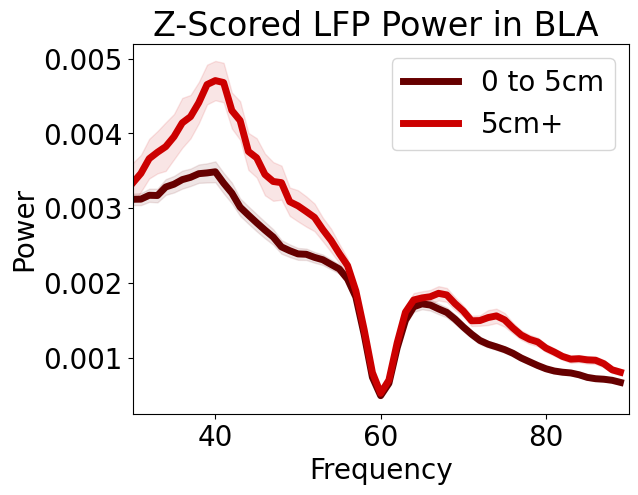

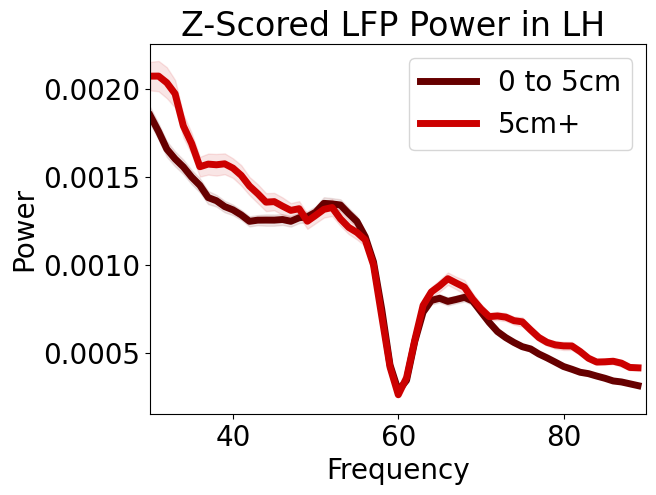

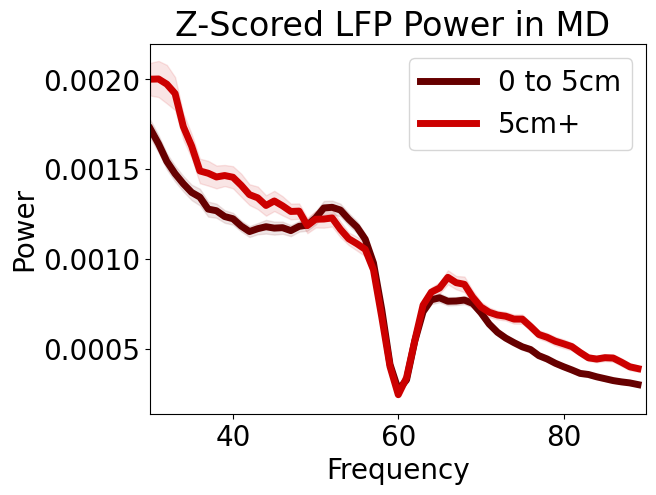

In [92]:
low_freq = 30
high_freq = 90
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[(grouped_all_trials_df["brain_region"] == region) & (grouped_all_trials_df["trial_or_baseline"] == "trial")]

    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {} ".format(region.split("_")[0]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq) 
    # plt.yscale("log")
    
    # Generate gradient colors
    gradient_colors = generate_gradient_colors("red", 20)
    
    for index, row in region_df.iterrows():           

        current_frequencies = ALL_FREQUENCIES[low_freq: high_freq]
        mean_power = row["mean_power"][low_freq: high_freq]
        sem_power = row["sem_power"][low_freq: high_freq]
            
        
        try:
            ax = sns.lineplot(x=current_frequencies, y=mean_power, \
            label="{}".format(BIN_TO_DISTANCE[row["distance_bin"]]), linewidth=5, color=gradient_colors[-(row["distance_bin"]+1) *4])
            
            plt.fill_between(current_frequencies, 
            mean_power - sem_power, mean_power + sem_power, \
            alpha=0.1, color=gradient_colors[-(row["distance_bin"]+1) *4])
        
        except Exception as e: 
            print(e)
            continue
    plt.legend()
    plt.savefig("./proc/distance_parsed_power/rce_distance_parsed_lfp_power_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[0]))

In [99]:
for col in MERGED_LFP_AND_SLEAP.columns:
    print(col)

time
recording_file
video_number
current_subject
mPFC_baseline_lfp_trace
mPFC_trial_lfp_trace
mPFC_baselineandtrial_lfp_trace
vHPC_baseline_lfp_trace
vHPC_trial_lfp_trace
vHPC_baselineandtrial_lfp_trace
BLA_baseline_lfp_trace
BLA_trial_lfp_trace
BLA_baselineandtrial_lfp_trace
LH_baseline_lfp_trace
LH_trial_lfp_trace
LH_baselineandtrial_lfp_trace
MD_baseline_lfp_trace
MD_trial_lfp_trace
MD_baselineandtrial_lfp_trace
recording_dir
time_stamp_index
video_file
video_frame
subject_info
competition_closeness
video_name
all_subjects
trial_outcome
lfp_index
baseline_lfp_timestamp_range
trial_lfp_timestamp_range
baseline_ephys_timestamp_range
trial_ephys_timestamp_range
baseline_videoframe_range
trial_videoframe_range
trial_number
Cohort
spike_interface_mPFC
spike_interface_vHPC
spike_interface_BLA
spike_interface_LH
spike_interface_MD
file_path
start_frame
stop_frame
individual_subj
all_subj
recording_name
track_names
subject_and_tracks_list
subject_id
agent_id
corner_path
corner_parts
bottom_

In [101]:
MERGED_LFP_AND_SLEAP["mPFC_trial_theta_all_window_power"].iloc[0]

array([0.05145565, 0.03905796, 0.02305128, 0.01624555, 0.01944759,
       0.07869598, 0.07297596, 0.03502546, 0.03579653, 0.04065072,
       0.05168672, 0.0690392 , 0.05832283, 0.04374253, 0.05977493,
       0.08329122, 0.10991563, 0.06065595, 0.02070129])

In [ ]:
low_freq = 12
high_freq = 31
for region in grouped_all_trials_df["region_and_baseline_or_trial"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["region_and_baseline_or_trial"] == region]

    for outcome in region_df["trial_outcome"].unique():
        fig, ax = plt.subplots()
        plt.title("Z-Scored LFP Power in {} for {}".format(region.split("_")[0], outcome))
        plt.xlabel("Frequency")
        plt.ylabel("Power")
        plt.xlim(low_freq, high_freq) 
        # plt.yscale("log")
        plt.ylim(0, 0.015)
        
        outcome_df = region_df[(region_df["trial_outcome"] == outcome)]
        # Generate gradient colors
        gradient_colors = generate_gradient_colors(OUTCOME_TO_COLOR[outcome], 20)
        
        for index, row in outcome_df.iterrows():           
            current_frequencies = ALL_FREQUENCIES[low_freq: high_freq]
            mean_power = row["mean_power"][low_freq: high_freq]
            sem_power = row["sem_power"][low_freq: high_freq]
                
            
            try:
                ax = sns.lineplot(x=current_frequencies, y=mean_power, \
                label="{} {}".format(outcome, BIN_TO_DISTANCE[row["distance_bin"]]), linewidth=3, color=gradient_colors[-(row["distance_bin"]+1) *4])
                
                plt.fill_between(current_frequencies, 
                mean_power - sem_power, mean_power + sem_power, \
                alpha=0.1, color=gradient_colors[-(row["distance_bin"]+1) *4])
            
            except Exception as e: 
                print(e)
                continue
        plt.legend()
        plt.savefig("./proc/distance_parsed_power/rce_distance_parsed_lfp_power_freq_{}_to_{}_region_{}_{}.png".format(low_freq, high_freq, region.split("_")[0], outcome))

In [104]:
region_df

distance_bin                       region_and_baseline_or_trial  \
0             0  mPFC_baseline_distance_parsed_window_averaged_...   
1             1  mPFC_baseline_distance_parsed_window_averaged_...   

                                               power brain_region  \
0  [[0.003349504797072138, 0.011918596681862672, ...         mPFC   
1  [[0.011947254289697694, 0.011967486126203276, ...         mPFC   

  trial_or_baseline                                         mean_power  \
0          baseline  [0.01743535859737272, 0.020249621342059012, 0....   
1          baseline  [0.029716946031178793, 0.03149701031175347, 0....   

                                           std_power  \
0  [0.052788538728824864, 0.04285147534760311, 0....   
1  [0.16780265891668533, 0.16170666245984866, 0.1...   

                                            n_trials  \
0  [159, 159, 159, 159, 159, 159, 159, 159, 159, ...   
1  [111, 111, 111, 111, 111, 111, 111, 111, 111, ...   

                                           sem_power  
0  [0.004186403434663822, 0.003398343047477861, 0...  
1  [0.015927123541930127, 0.015348517164021584, 0...

In [107]:
all_cols = [ 'mPFC_trial_theta_all_window_power',
 'mPFC_trial_beta_all_window_power',
 'mPFC_trial_gamma_all_window_power',
 'vHPC_trial_theta_all_window_power',
 'vHPC_trial_beta_all_window_power',
 'vHPC_trial_gamma_all_window_power',
 'BLA_trial_theta_all_window_power',
 'BLA_trial_beta_all_window_power',
 'BLA_trial_gamma_all_window_power',
 'LH_trial_theta_all_window_power',
 'LH_trial_beta_all_window_power',
 'LH_trial_gamma_all_window_power',
 'MD_trial_theta_all_window_power',
 'MD_trial_beta_all_window_power',
 'MD_trial_gamma_all_window_power']

In [ ]:
MERGED_LFP_AND_SLEAP["chtrial_subject_thorax_location"].iloc[]

In [ ]:
for col in all_cols:
    for outcome in MERGED_LFP_AND_SLEAP["trial_outcome"].unique():
        outcome_df = MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP["trial_outcome"] == outcome]

        # fig, ax = plt.subplots()
        fig = plt.figure(figsize = (10, 7))
        ax = plt.axes(projection ="3d")
        plt.title("Z-Scored LFP Power in {} for {}".format(region.split("_")[0], outcome))
        plt.xlabel("X coordinate")
        plt.ylabel("Y Coordinate")
        # plt.xlim(low_freq, high_freq) 
        # plt.yscale("log")
        # plt.ylim(0, 0.015)
        # Creating figure
        for index, row in outcome_df.iterrows():
            
            ax.scatter3D(x, y, z, color = "green")
        

        


In [103]:
low_freq = 12
high_freq = 31
for region in MERGED_LFP_AND_SLEAP["region_and_baseline_or_trial"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["region_and_baseline_or_trial"] == region]

    for outcome in region_df["trial_outcome"].unique():
        # fig, ax = plt.subplots()
        fig = plt.figure(figsize = (10, 7))
        ax = plt.axes(projection ="3d")
        plt.title("Z-Scored LFP Power in {} for {}".format(region.split("_")[0], outcome))
        plt.xlabel("X coordinate")
        plt.ylabel("Y Coordinate")
        # plt.xlim(low_freq, high_freq) 
        # plt.yscale("log")
        # plt.ylim(0, 0.015)
        # Creating figure
        

        
        outcome_df = region_df[(region_df["trial_outcome"] == outcome)]

        

        # plt.legend()
        break
        # plt.savefig("./proc/distance_parsed_power/rce_distance_parsed_lfp_power_freq_{}_to_{}_region_{}_{}.png".format(low_freq, high_freq, region.split("_")[0], outcome))
    break

KeyError: 'trial_outcome'

In [ ]:
MERGED_LFP_AND_SLEAP

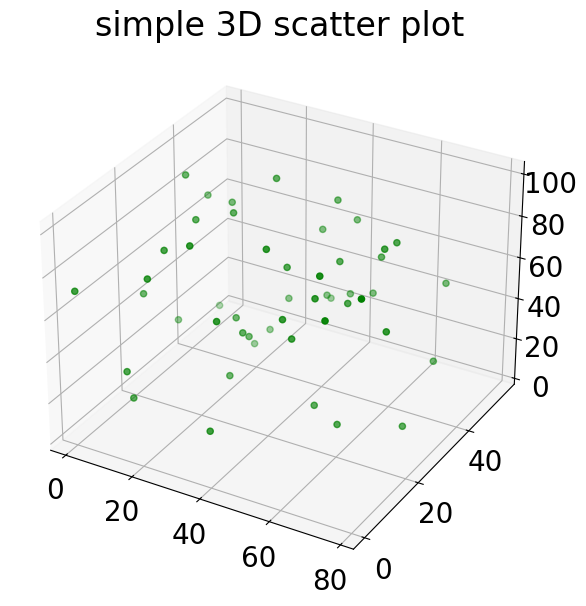

In [102]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
 
# Creating dataset
z = np.random.randint(100, size =(50))
x = np.random.randint(80, size =(50))
y = np.random.randint(60, size =(50))
 
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(x, y, z, color = "green")
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

In [105]:
MERGED_LFP_AND_SLEAP["mPFC_trial_theta_all_window_power"].iloc[0]

array([0.05145565, 0.03905796, 0.02305128, 0.01624555, 0.01944759,
       0.07869598, 0.07297596, 0.03502546, 0.03579653, 0.04065072,
       0.05168672, 0.0690392 , 0.05832283, 0.04374253, 0.05977493,
       0.08329122, 0.10991563, 0.06065595, 0.02070129])

# OLD CODE BELOW

In [96]:
raise ValueError()

ValueError: 

# Parse power by lower distance

In [94]:
MERGED_LFP_AND_SLEAP.head()

time                                     recording_file  video_number  \
0   4509412  20230617_115521_standard_comp_to_omission_D1_s...           1.0   
1   6909411  20230617_115521_standard_comp_to_omission_D1_s...           1.0   
2   9209413  20230617_115521_standard_comp_to_omission_D1_s...           1.0   
3  13109412  20230617_115521_standard_comp_to_omission_D1_s...           1.0   
4  16509409  20230617_115521_standard_comp_to_omission_D1_s...           1.0   

  current_subject                            mPFC_baseline_lfp_trace  \
0             1.1  [-1.2365645, -1.3354121, -1.5621803, -1.494343...   
1             1.1  [0.24421181, 0.2616555, 0.4380307, 0.4729181, ...   
2             1.1  [1.7249881, 1.7424319, 1.6862243, 1.4323217, 0...   
3             1.1  [-0.89156693, -1.0485603, -0.7539555, -0.38182...   
4             1.1  [0.79853386, 1.0737567, 1.3412267, 1.6145114, ...   

                                mPFC_trial_lfp_trace  \
0  [-1.0679421, -0.7713992, -0.69580984, -1.13190...   
1  [-0.8605559, -0.6492933, -0.37407047, -0.05233...   
2  [-0.094971254, -0.16862243, -0.12404409, -0.22...   
3  [2.3956015, 2.1804626, 1.9730763, 1.9750146, 2...   
4  [-1.5835004, -1.6067586, -1.2113681, -0.819853...   

                     mPFC_baselineandtrial_lfp_trace  \
0  [-1.2365645, -1.3354121, -1.5621803, -1.494343...   
1  [0.24421181, 0.2616555, 0.4380307, 0.4729181, ...   
2  [1.7249881, 1.7424319, 1.6862243, 1.4323217, 0...   
3  [-0.89156693, -1.0485603, -0.7539555, -0.38182...   
4  [0.79853386, 1.0737567, 1.3412267, 1.6145114, ...   

                             vHPC_baseline_lfp_trace  \
0  [0.20910755, 0.39620376, 0.7075067, 1.040821, ...   
1  [0.5377051, 0.70907897, 0.5219827, 0.3506089, ...   
2  [0.7531016, 0.1776628, -0.37890917, -0.6980733...   
3  [-0.72480136, -0.8631582, -0.610028, 0.1776628...   
4  [0.067606196, 0.3679035, 0.63203937, 0.7059344...   

                                vHPC_trial_lfp_trace  \
0  [-2.4841347, -2.1523926, -1.564376, -1.139872,...   
1  [-0.31916416, -0.08647305, 0.19810188, 0.49525...   
2  [1.2908068, 1.0486822, 0.79712427, 0.55971646,...   
3  [2.0847864, 1.889829, 1.8442342, 1.9480019, 2....   
4  [-1.2845178, -1.1807501, -0.8128466, -0.452804...   

                     vHPC_baselineandtrial_lfp_trace  ...  \
0  [0.20910755, 0.39620376, 0.7075067, 1.040821, ...  ...   
1  [0.5377051, 0.70907897, 0.5219827, 0.3506089, ...  ...   
2  [0.7531016, 0.1776628, -0.37890917, -0.6980733...  ...   
3  [-0.72480136, -0.8631582, -0.610028, 0.1776628...  ...   
4  [0.067606196, 0.3679035, 0.63203937, 0.7059344...  ...   

                   vHPC_trial_gamma_all_window_power  \
0  [0.004680677235180503, 0.004165028006256168, 0...   
1  [0.003269849569467275, 0.004903569885563807, 0...   
2  [0.002782682395891564, 0.002336317134091798, 0...   
3  [0.003176124256915659, 0.002229847951168046, 0...   
4  [0.0016888840340364888, 0.001627018926638573, ...   

                    BLA_trial_theta_all_window_power  \
0  [0.12036119574342755, 0.0890754410993826, 0.08...   
1  [0.08623752733833975, 0.07487283358377234, 0.0...   
2  [0.05770472674702558, 0.03710141982881941, 0.0...   
3  [0.021282817197667104, 0.028287246964022385, 0...   
4  [0.0125221538542442, 0.02514142952979569, 0.02...   

                     BLA_trial_beta_all_window_power  \
0  [0.003245983783951066, 0.0028179510223004063, ...   
1  [0.002160245513306396, 0.0022474855968851373, ...   
2  [0.004955004258230451, 0.003098675940848164, 0...   
3  [0.002851511448395812, 0.002847397247918834, 0...   
4  [0.0036677494243505747, 0.003459508796045385, ...   

                    BLA_trial_gamma_all_window_power  \
0  [0.0028402825530031675, 0.0027044995825134385,...   
1  [0.0020884354611873687, 0.002529771725251694, ...   
2  [0.0022452016787588448, 0.0021529779114350415,...   
3  [0.003804766254600959, 0.0031062083715139325, ...   
4  [0.0027096361603180796, 0.0023708766655605915,...   

                     LH_trial_

In [95]:

MERGED_LFP_AND_SLEAP["binned_trial_distance_mask"] = MERGED_LFP_AND_SLEAP["trial_chunked_subject_thorax_to_reward_port_distance"].apply(lambda x: [index for index, num in enumerate(x) if MIN_DISTANCE <= num <= MAX_DISTANCE])

MERGED_LFP_AND_SLEAP["binned_baseline_distance_mask"] = MERGED_LFP_AND_SLEAP["baseline_chunked_subject_thorax_to_reward_port_distance"].apply(lambda x: [index for index, num in enumerate(x) if MIN_DISTANCE <= num <= MAX_DISTANCE])

for col in baseline_windowed_power_columns:
    region_and_baseline_or_trial = "_".join(col.split("_")[:2])
    MERGED_LFP_AND_SLEAP["{}_distance_parsed_window_averaged_power".format(region_and_baseline_or_trial)] = MERGED_LFP_AND_SLEAP.apply(lambda x: np.nanmean(np.array([x[col][i] for i in x["binned_baseline_distance_mask"]]), axis=0), axis=1)

for col in trial_windowed_power_columns:
    region_and_baseline_or_trial = "_".join(col.split("_")[:2])
    MERGED_LFP_AND_SLEAP["{}_distance_parsed_window_averaged_power".format(region_and_baseline_or_trial)] = MERGED_LFP_AND_SLEAP.apply(lambda x: np.nanmean(np.array([x[col][i] for i in x["binned_trial_distance_mask"]]), axis=0), axis=1)



KeyError: 'trial_chunked_subject_thorax_to_reward_port_distance'

In [ ]:
for col in MERGED_LFP_AND_SLEAP.columns:
    print(col)

In [ ]:
DISTANCE_PARSED_MERGED_LFP_AND_SLEAP["trial_outcome"]

In [ ]:
grouped_all_trials_df = DISTANCE_PARSED_MERGED_LFP_AND_SLEAP.groupby(['trial_outcome']).agg({k: lambda x: np.vstack([arr for arr in x.tolist() if not np.any(np.isnan(arr))]) for k in window_averaged_power_columns}).reset_index()

In [ ]:
grouped_all_trials_df = pd.melt(grouped_all_trials_df, id_vars =['trial_outcome'], value_vars =grouped_all_trials_df.drop(columns=["trial_outcome"]).columns, value_name="power", var_name="region_and_baseline_or_trial") 

In [ ]:
grouped_all_trials_df.head()

In [ ]:
grouped_all_trials_df["brain_region"] = grouped_all_trials_df["region_and_baseline_or_trial"].apply(lambda x: x.split("_")[0].strip())

In [ ]:
grouped_all_trials_df["trial_or_baseline"] = grouped_all_trials_df["region_and_baseline_or_trial"].apply(lambda x: x.split("_")[1].strip())

In [ ]:
grouped_all_trials_df["mean_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanmean(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["std_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanstd(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["n_trials"] = grouped_all_trials_df["power"].apply(lambda x: np.sum(~np.isnan(x), axis=0))

In [ ]:
grouped_all_trials_df["sem_power"] = grouped_all_trials_df.apply(lambda x: x["std_power"] / np.sqrt(x["n_trials"]), axis=1)

In [ ]:
grouped_all_trials_df

In [ ]:
OUTCOME_TO_COLOR

In [ ]:
FONTSIZE=20

In [ ]:
font = {'weight' : 'medium',
        'size'   : 15}

matplotlib.rc('font', **font)

In [ ]:
BAND_TO_FREQ

In [ ]:
BAND_TO_FREQ_PLOT = {'theta': (6, 10), 'beta': (20, 30), 'gamma': (30, 50)}
BAND_TO_FREQ_COLOR = {'theta': "red", 'beta': "blue", 'gamma': "green"}

BAND_TO_FREQ_PLOT = {'theta': (6, 10), 'gamma': (30, 50)}
BAND_TO_FREQ_COLOR = {'theta': "red", 'gamma': "green"}

In [ ]:
low_freq = 0
high_freq = 51
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[(grouped_all_trials_df["brain_region"] == region) & (grouped_all_trials_df["trial_or_baseline"] == "trial")]

    fig, ax = plt.subplots()
    plt.title("Power Spectra {} ".format(region.split("_")[0]), fontsize=FONTSIZE)
    plt.xlabel("Frequency (Hz)", fontsize=FONTSIZE)
    plt.ylabel("Power (a.u.)", fontsize=FONTSIZE)
    plt.xlim(low_freq, high_freq) 
    plt.yscale("log")
        
    for index, row in region_df.iterrows():           

        current_frequencies = ALL_FREQUENCIES[low_freq: high_freq]
        mean_power = row["mean_power"][low_freq: high_freq]
        sem_power = row["sem_power"][low_freq: high_freq]
            
        
        try:
            ax = sns.lineplot(x=current_frequencies, y=mean_power, \
            label="{}".format(row["trial_outcome"]), linewidth=5, color=OUTCOME_TO_COLOR[row["trial_outcome"]])
            
            plt.fill_between(current_frequencies, 
            mean_power - sem_power, mean_power + sem_power, \
            alpha=0.1, color=OUTCOME_TO_COLOR[row["trial_outcome"]])
        
        except Exception as e: 
            print(e)
            continue
    for band, (min_freq, max_freq) in BAND_TO_FREQ_PLOT.items():
        ax.axvspan(min_freq, max_freq, facecolor=BAND_TO_FREQ_COLOR[band], alpha=0.1, label=band)
    plt.legend(fontsize=15, ncol=2)


    plt.tight_layout()
    plt.savefig("./proc/distance_parsed_power/rce_distance_parsed_lfp_power_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[0]))
    plt.savefig("./proc/distance_parsed_power/rce_distance_parsed_lfp_power_freq_{}_to_{}_region_{}.eps".format(low_freq, high_freq, region.split("_")[0]))

# Plotting the correlations

In [ ]:
MERGED_LFP_AND_SLEAP["trial_chunked_agent_thorax_to_reward_port_distance"].iloc[0].shape

In [ ]:
MERGED_LFP_AND_SLEAP["BLA_trial_all_window_power"].iloc[0].shape

In [ ]:
ALL_REGION_BAND_COL

In [ ]:
MERGED_LFP_AND_SLEAP

In [ ]:
MERGED_LFP_AND_SLEAP.columns

In [ ]:
MERGED_LFP_AND_SLEAP["trial_chunked_subject_thorax_to_reward_port_distance"].iloc[0]


In [ ]:
MERGED_LFP_AND_SLEAP["current_subject"].unique()

In [ ]:
subject_df = MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP["current_subject"] == "1.2"]

In [ ]:
def reject_outliers(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zeros(len(d))
    return s<m

In [ ]:
font = {'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)

plt.rcParams['figure.figsize'] = [6, 6]

for region_band_col in ALL_REGION_BAND_COL:
    region = region_band_col.split("_")[0]
    band = region_band_col.split("_")[2]
    for outcome in subject_df["trial_outcome"].unique():
        current_df = subject_df[subject_df["trial_outcome"] == outcome]
        y = np.concatenate(current_df[region_band_col].values)
        x = np.concatenate(current_df["trial_chunked_subject_thorax_to_reward_port_distance"].values)
        outlier_mask = reject_outliers(y)
        y = y[outlier_mask]
        x = x[outlier_mask]
        # outlier_mask = reject_outliers(x)
        # y = y[outlier_mask]
        # x = x[outlier_mask]
        
        # Perform linear regression to get the slope, intercept and r-value (correlation coefficient)
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        
        # Create a line of best fit using the slope and intercept
        line = slope * x + intercept
        
        # Create scatter plot
        plt.scatter(x=x, y=y, color=OUTCOME_TO_COLOR[outcome], label=outcome)
        
        # Plot line of best fit
        plt.plot(x, line, color=OUTCOME_TO_COLOR[outcome])
        
        # Add R² value to the plot
        # plt.text(0.1, 0.9, f'R = {r_value:.2f}', transform=plt.gca().transAxes)
        
        # Add labels and legend
        plt.title("Power correlation {} LFP".format(region_band_col), fontsize=20)
        plt.xlabel('{}'.format("Distance"))
        plt.ylabel('{} power'.format(region_band_col))
        plt.legend(loc="lower right")
        # ax.get_legend().remove()
        # plt.ylim(0,0.1)
        # plt.xlim(0,10)
        plt.tight_layout()
        # plt.savefig("./proc/power_correlation/all_condition_{}_{}_power_correlation_of_zscored_{}_lfp.png".format(region_1_basename, region_2_basename, band))
        # Display the plot
        plt.close
        continue
        plt.show()




In [ ]:
raise ValueError()

# Exporting Velocity Parsed dataframe for plotting

In [ ]:
EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP = DISTANCE_PARSED_MERGED_LFP_AND_SLEAP[DISTANCE_PARSED_MERGED_LFP_AND_SLEAP["distance_bin"] == 0].copy()

In [ ]:
EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP = EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP.drop(columns=[col for col in EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP.columns if "baseline" in col], errors="ignore")

In [ ]:
EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP = EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP.drop(columns=[col for col in EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP.columns if "trace" in col], errors="ignore")

In [ ]:
EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP = pd.melt(EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP, id_vars=EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP.columns[:19], value_vars=[col for col in EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP.columns if "distance_parsed_window_averaged_power" in col], value_name="power", var_name="region_and_baseline_or_trial")




In [ ]:
EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP["brain_region"] = EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP["region_and_baseline_or_trial"].apply(lambda x:x.split("_")[0])
EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP["trial_or_baseline"] = EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP["region_and_baseline_or_trial"].apply(lambda x:x.split("_")[1])

In [ ]:
EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP = EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP.dropna(subset=["power"])

In [ ]:
for band, (min_freq, max_freq) in BAND_TO_FREQ.items():
    EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP["mean_{}_power".format(band)] = EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP["power"].apply(lambda x: np.nanmean(x[min_freq:max_freq]))

In [ ]:
EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP.to_pickle("./proc/rce_distance_parsed_power_spectra_region_and_baselinetrial_rows.pkl")

In [ ]:
EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP

In [ ]:
for col in EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP.columns[:19]:
    print(col)

# Calculating the distance parsed average power for each frequency band

In [ ]:
BAND_TO_FREQ

In [ ]:
distance_parsed_window_averaged_power_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if "distance_parsed_window_averaged_power" in col]

In [ ]:
distance_parsed_window_averaged_power_columns

- Removing all trials that have a high distance trhoguhout

In [ ]:
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP["binned_trial_distance_mask"].map(len) >= 1]

In [ ]:
for col in distance_parsed_window_averaged_power_columns:
    region_base_name = "_".join(col.split("_")[:2])
    print(region_base_name)
    for band, (min_freq, max_freq) in BAND_TO_FREQ.items():
        print(band)
        MERGED_LFP_AND_SLEAP["{}_{}_all_power".format(region_base_name, band)] = MERGED_LFP_AND_SLEAP[col].apply(lambda x: x[min_freq:max_freq])
        MERGED_LFP_AND_SLEAP["{}_{}_mean_power".format(region_base_name, band)] = MERGED_LFP_AND_SLEAP["{}_{}_all_power".format(region_base_name, band)].apply(lambda x: x.mean())

In [ ]:
# MD_trial_mean_gamma_power
mean_power_col = [col for col in MERGED_LFP_AND_SLEAP.columns if "mean_power" in col]

In [ ]:
mean_power_df = pd.DataFrame(MERGED_LFP_AND_SLEAP.groupby(['trial_outcome'])[mean_power_col].mean()).reset_index()

In [ ]:
mean_power_df["color"] = mean_power_df["trial_outcome"].map(OUTCOME_TO_COLOR)

In [ ]:
sem_power_df = pd.DataFrame(MERGED_LFP_AND_SLEAP.groupby(['trial_outcome'])[mean_power_col].sem()).reset_index()

In [ ]:
mean_power_df

In [ ]:
OUTCOME_COMPARISONS

In [ ]:
rank_sum_dict = []
for col in mean_power_col:
    region = col.split("_")[0]
    baseline_or_trial = col.split("_")[1]
    band = col.split("_")[2]
    if baseline_or_trial != "trial":
        continue
    for key, (first_outcome, second_outcome) in  OUTCOME_COMPARISONS.items():
        first_df = MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP["trial_outcome"] == first_outcome]
        second_df = MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP["trial_outcome"] == second_outcome]
        statistic, p_value = mannwhitneyu(first_df[col], second_df[col], alternative='two-sided')
        rank_sum_dict.append({"region": region, "band": band, "comparison": key, "mannwhitneyu_statistic": statistic, "mannwhitneyu_pvalue": p_value, "all_outcomes": set([first_outcome, second_outcome])})
rank_sum_df = pd.DataFrame(rank_sum_dict)

In [ ]:
rank_sum_df.head()

In [ ]:
current_df

In [ ]:
round(mean_power_df[[col for col in mean_power_df.columns if "theta" in col]].to_numpy().max() * 1.25, 3)

In [ ]:
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.copy()
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "multitaper" in col], errors="ignore").copy()
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "connectivity" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "frequencies" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "spike_interface" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "distance_parsed_window_averaged_power" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "all_window_power" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "all_power" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "window_averaged_power" in col], errors="ignore")

